In [5]:
import csv
from pathlib import Path
import os

def write_to_csv_parameters(filename):
    fieldnames = ['Date', 'Item Name', 'p', 'd', 'q']
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        writer.writerow(fieldnames)
        
        # writer.writerow([today_date, product_name, p, d, q])
        
base_dir = Path(os.getenv("BASE_DIRECTORY"))
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
write_to_csv_parameters(filename)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/fruits/fruits_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/fruits_saved_models"
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
allYearsFilename = base_dir / "data/fruits/fruits_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            # print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        # print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        write_to_csv(data, allYearsFilename)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("FRUITS_WEBPAGE_PATH"),
                                           os.getenv("FRUITS_DATE_PATH"),
                                           os.getenv("FRUITS_SUBMIT_BUTTON_PATH"),
                                           os.getenv("FRUITS_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()


# Storing the models on spaces

In [1]:
pip install boto3

  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/139.6 kB ? eta -:--:--
   -------- ------------------------------- 30.7/139.6 kB 1.4 MB/s eta 0:00:01
   ----------- --------------------------- 41.0/139.6 kB 667.8 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.6 kB 550.5 kB/s eta 0:00:01
   ------------------------- ------------- 92.2/139.6 kB 585.1 kB/s eta 0:00:01
   ------------------------------ ------- 112.6/139.6 kB 598.8 kB/s eta 0:00:01
   -------------------------------------- 139.6/139.6 kB 517.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.5 MB 487.6 kB/s eta 0:00:28
   ---------------------------------------- 0.1/13.5 MB 544.7 kB/s eta 0:00:25
   ---------------------------------------- 0.1/13.5 MB 521.8 kB/s eta 0:00:26
   -----


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


         Date Item Name  Low Price  Average Price  High Price
0  13-12-2024     જામફળ        400            700        1000
1  13-12-2024      દાડમ        500           1050        1600
2  13-12-2024     સફરજન       1000           2300        3600
3  13-12-2024      ચીકુ        600            800        1000
4  13-12-2024    પોપૈયા        500            550         600
['જામફળ' 'દાડમ' 'સફરજન' 'ચીકુ' 'પોપૈયા' 'સીતાફળ' 'કેળા' 'સંતરા' 'તરબૂચ'
 'સ્ટ્રોબેરી' 'માલટા' 'ક્મલમ' 'ગુલાબ' 'આબલી' 'મોસંબી' 'ટેટી' 'બોર'
 'દ્રાક્ષ' 'આલુચા' 'કીવી' 'અનાનસ' 'લિચી' 'ઓરેંજ' 'હાફુસ કેરી'
 'લાલબાગ કેરી' 'બદામ કેરી' 'સૂ્દરી કેરી' 'કેસર કેરી' 'તોતાપુરી કેરી']
Data older than 15-12-2024 has been removed.
Before dropping the column:
         Date Some Extra Column Item Name Low Price Average Price High Price
0  14-04-2025                 1      દાડમ       600          1000        800
1  14-04-2025                 2     સફરજન      1600          4000       2800
2  14-04-2025                 3      ચીકુ       300  

<Figure size 1200x600 with 0 Axes>

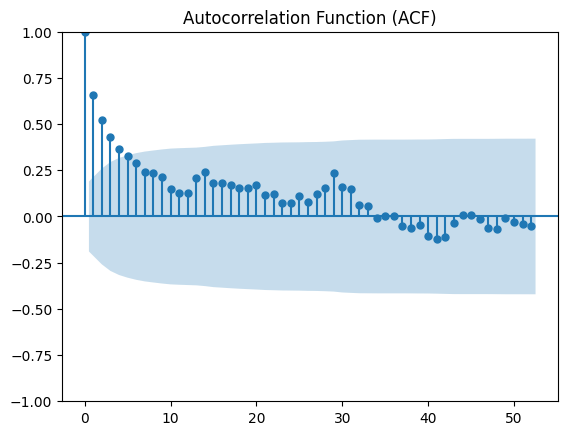

<Figure size 1200x600 with 0 Axes>

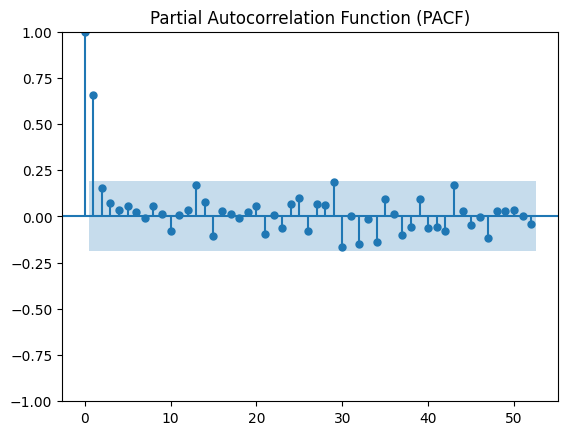


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  107
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -677.846
Date:                Mon, 14 Apr 2025   AIC                           1361.693
Time:                        14:52:49   BIC                           1369.711
Sample:                             0   HQIC                          1364.943
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        645.1946     42.648     15.128      0.000     561.606     728.783
ar.L1          0.6770      0.07

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for જામફળ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_1504c4369bfb4acd29b2e036ed2ec032.pkl
Model for જામફળ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_1504c4369bfb4acd29b2e036ed2ec032.pkl
દાડમ size:  114
False
Checking stationarity for the raw price data of દાડમ:

ADF Test Results:
ADF Statistic: -3.3781
p-value: 0.0117
Critical Value 1%: -3.4936
Critical Value 5%: -2.8892
Critical Value 10%: -2.5815
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.3781
p-value: 0.0117
Critical Value 1%: -3.4936
Critical Value 5%: -2.8892
Critical Value 10%: -2.5815
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [ 6 15 20]
Significant spikes in PACF (p): 5 at lags [ 6  8 14 19 20]


<Figure size 1200x600 with 0 Axes>

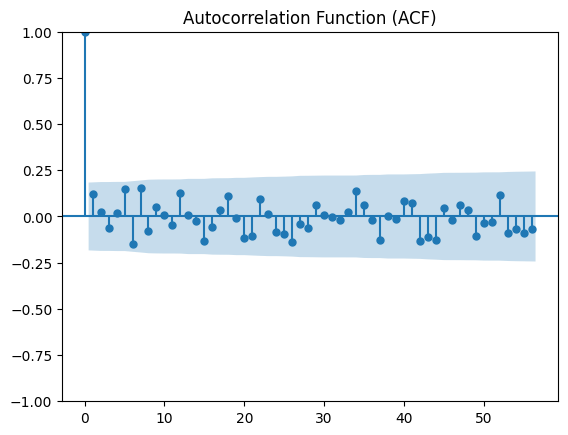

<Figure size 1200x600 with 0 Axes>

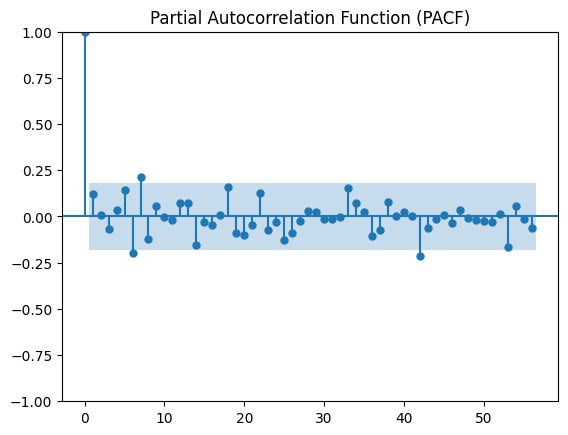


Fitting ARIMA model with order (5, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  114
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -780.492
Date:                Mon, 14 Apr 2025   AIC                           1580.984
Time:                        14:52:51   BIC                           1608.346
Sample:                             0   HQIC                          1592.089
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1113.1637     28.773     38.688      0.000    1056.770    1169.557
ar.L1         -1.2429      0.798     -1.557      0.119      -2.808       0.3

<Figure size 1200x600 with 0 Axes>

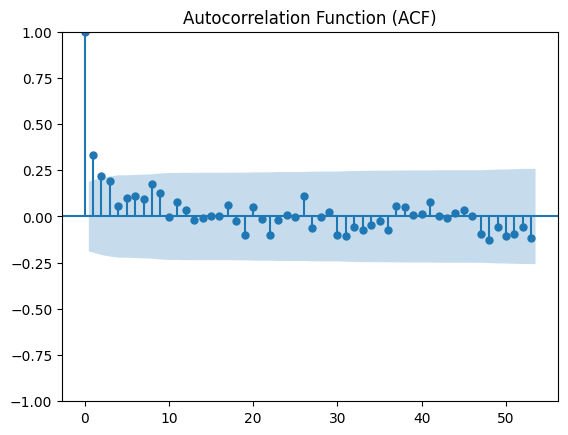

<Figure size 1200x600 with 0 Axes>

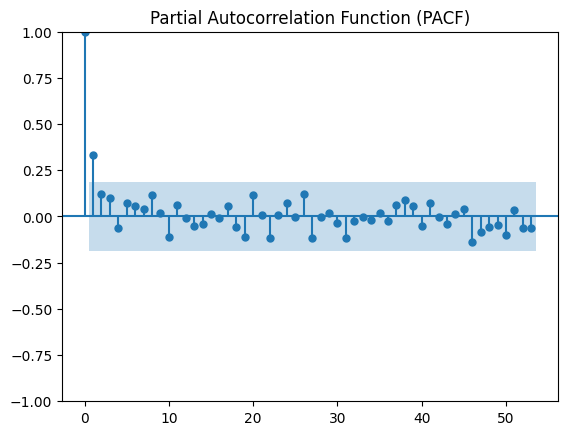


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  108
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -766.626
Date:                Mon, 14 Apr 2025   AIC                           1541.252
Time:                        14:52:56   BIC                           1551.981
Sample:                             0   HQIC                          1545.602
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2192.0371     48.035     45.634      0.000    2097.890    2286.184
ar.L1          0.2893      0.09

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સફરજન uploaded to Spaces at ml_models/fruits_saved_models/arima_model_af53e0d54a1037dd6713b287013502b8.pkl
Model for સફરજન saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_af53e0d54a1037dd6713b287013502b8.pkl
ચીકુ size:  98
False
Checking stationarity for the raw price data of ચીકુ:

ADF Test Results:
ADF Statistic: -4.7700
p-value: 0.0001
Critical Value 1%: -3.4996
Critical Value 5%: -2.8918
Critical Value 10%: -2.5829
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7700
p-value: 0.0001
Critical Value 1%: -3.4996
Critical Value 5%: -2.8918
Critical Value 10%: -2.5829
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 3 at lags [13 15 16]


<Figure size 1200x600 with 0 Axes>

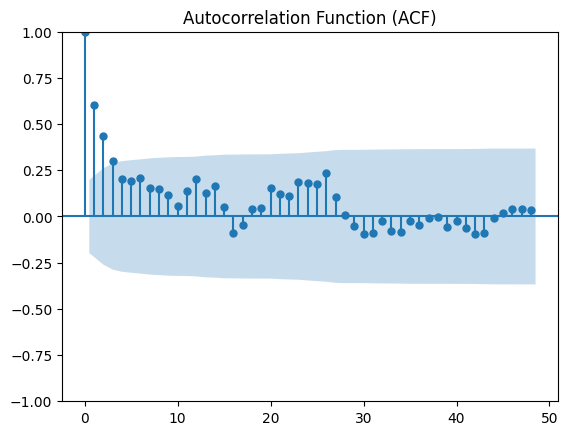

<Figure size 1200x600 with 0 Axes>

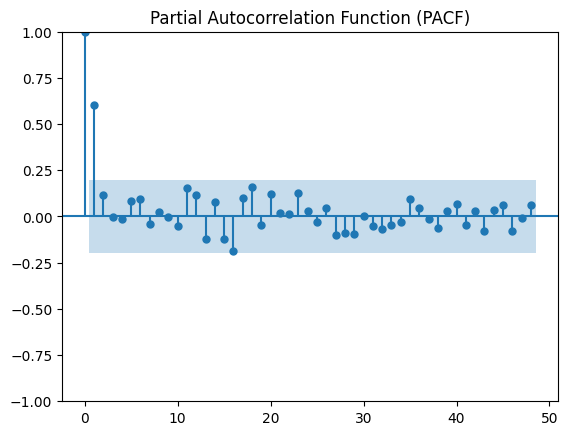


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   98
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -603.473
Date:                Mon, 14 Apr 2025   AIC                           1216.947
Time:                        14:52:59   BIC                           1229.872
Sample:                             0   HQIC                          1222.175
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        670.2129     35.838     18.701      0.000     599.972     740.454
ar.L1          0.5316      0.10

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ચીકુ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_3da490d055119f2d5fa18ff29a9c3ef6.pkl
Model for ચીકુ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_3da490d055119f2d5fa18ff29a9c3ef6.pkl
પોપૈયા size:  64
False
Checking stationarity for the raw price data of પોપૈયા:

ADF Test Results:
ADF Statistic: -3.2913
p-value: 0.0153
Critical Value 1%: -3.5405
Critical Value 5%: -2.9094
Critical Value 10%: -2.5923
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.2913
p-value: 0.0153
Critical Value 1%: -3.5405
Critical Value 5%: -2.9094
Critical Value 10%: -2.5923
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [8]
Significant spikes in PACF (p): 5 at lags [ 6  8 12 16 18]


<Figure size 1200x600 with 0 Axes>

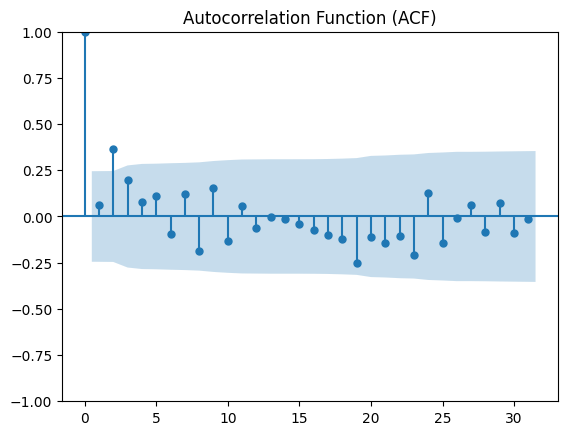

<Figure size 1200x600 with 0 Axes>

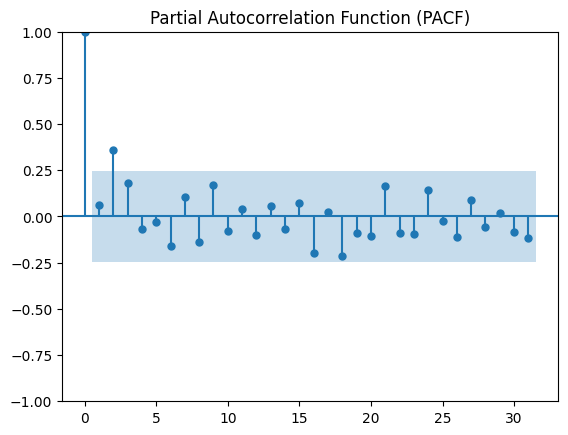


Fitting ARIMA model with order (5, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   64
Model:                 ARIMA(5, 0, 1)   Log Likelihood                -377.391
Date:                Mon, 14 Apr 2025   AIC                            770.782
Time:                        14:53:02   BIC                            788.053
Sample:                             0   HQIC                           777.585
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        428.2769     31.208     13.723      0.000     367.110     489.444
ar.L1         -0.8424      0.169     -4.986      0.000      -1.173      -0.5

<Figure size 1200x600 with 0 Axes>

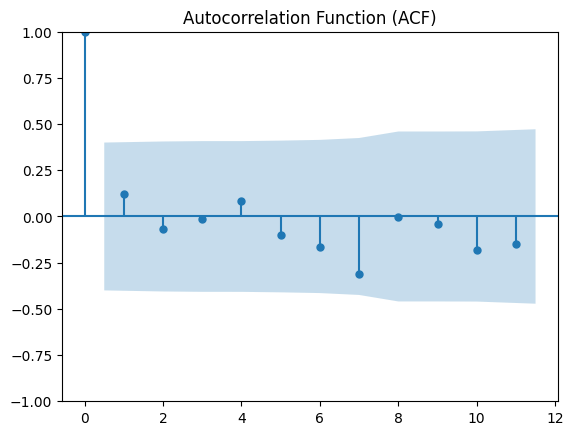

<Figure size 1200x600 with 0 Axes>

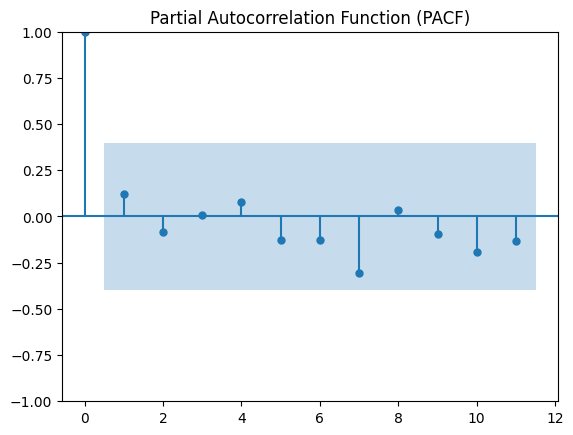


Fitting ARIMA model with order (3, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -154.867
Date:                Mon, 14 Apr 2025   AIC                            321.735
Time:                        14:53:06   BIC                            328.803
Sample:                             0   HQIC                           323.610
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        790.1624     32.453     24.348      0.000     726.557     853.768
ar.L1         -0.7334      0.30

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સીતાફળ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_50da7090132fa848416c132f8b05fab8.pkl
Model for સીતાફળ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_50da7090132fa848416c132f8b05fab8.pkl
કેળા size:  108
False
Checking stationarity for the raw price data of કેળા:

ADF Test Results:
ADF Statistic: -6.1101
p-value: 0.0000
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.1101
p-value: 0.0000
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [ 3 11]
Significant spikes in PACF (p): 4 at lags [ 3 11 14 17]


<Figure size 1200x600 with 0 Axes>

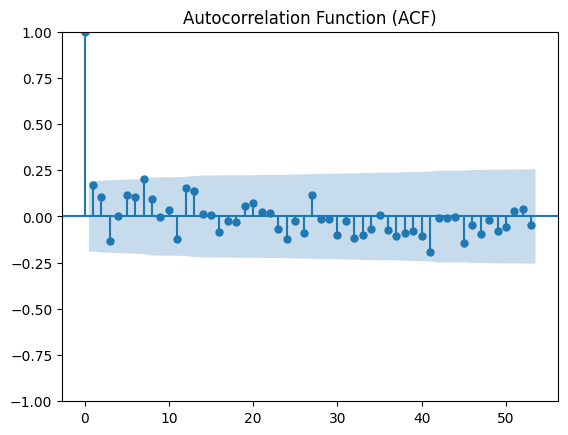

<Figure size 1200x600 with 0 Axes>

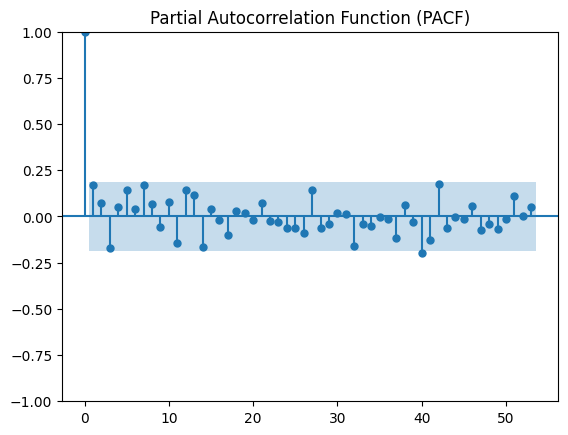


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  108
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -490.606
Date:                Mon, 14 Apr 2025   AIC                            997.211
Time:                        14:53:08   BIC                           1018.668
Sample:                             0   HQIC                          1005.911
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        505.0816      3.052    165.513      0.000     499.101     511.063
ar.L1         -1.1724      0.176     -6.653      0.000      -1.518      -0.8

<Figure size 1200x600 with 0 Axes>

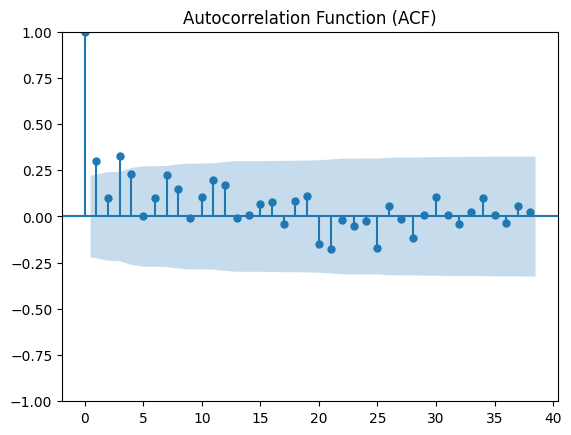

<Figure size 1200x600 with 0 Axes>

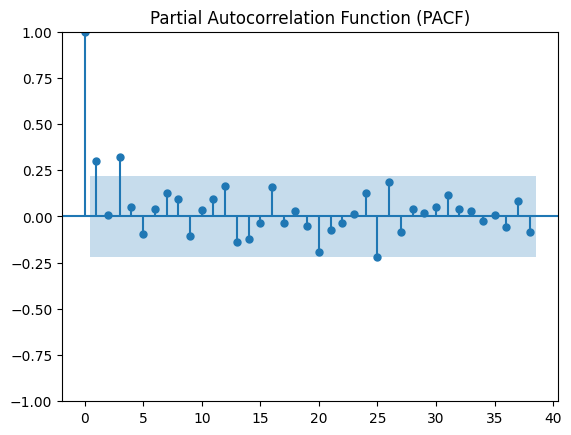


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -605.694
Date:                Mon, 14 Apr 2025   AIC                           1221.387
Time:                        14:53:12   BIC                           1233.234
Sample:                             0   HQIC                          1226.133
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1090.6329    127.938      8.525      0.000     839.878    1341.388
ar.L1          0.2225      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સંતરા uploaded to Spaces at ml_models/fruits_saved_models/arima_model_e5e4f6100a26c314e26a8cc71e15096d.pkl
Model for સંતરા saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_e5e4f6100a26c314e26a8cc71e15096d.pkl
તરબૂચ size:  94
False
Checking stationarity for the raw price data of તરબૂચ:

ADF Test Results:
ADF Statistic: -1.4708
p-value: 0.5479
Critical Value 1%: -3.5043
Critical Value 5%: -2.8939
Critical Value 10%: -2.5840
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -10.7505
p-value: 0.0000
Critical Value 1%: -3.5043
Critical Value 5%: -2.8939
Critical Value 10%: -2.5840
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -10.7505
p-value: 0.0000
Critical Value 1%: -3.5043
Critical Value 5%: -2.8939
Critical Value 10%: -2.5840
The series is stationary (no further differencing needed).
Sig

<Figure size 1200x600 with 0 Axes>

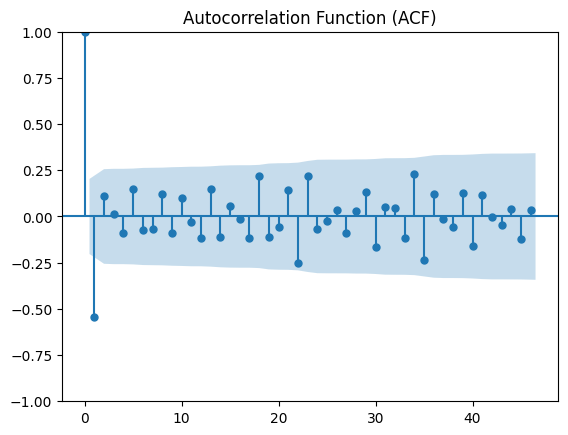

<Figure size 1200x600 with 0 Axes>

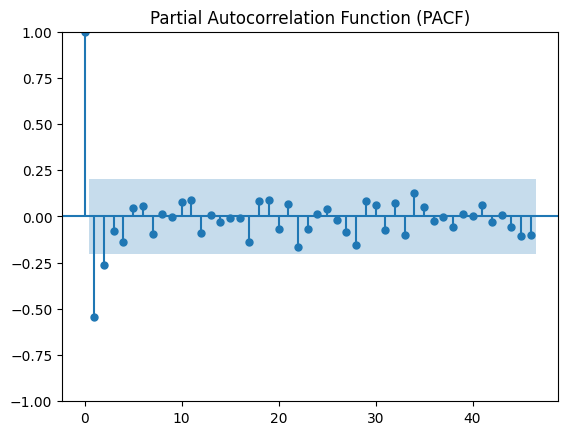


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   94
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -427.704
Date:                Mon, 14 Apr 2025   AIC                            861.407
Time:                        14:53:15   BIC                            869.005
Sample:                             0   HQIC                           864.475
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2310      0.156     -1.481      0.139      -0.537       0.075
ma.L1         -0.4738      0.15

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તરબૂચ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_7d0556adae3db00e807d8d48a94d171c.pkl
Model for તરબૂચ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_7d0556adae3db00e807d8d48a94d171c.pkl
સ્ટ્રોબેરી size:  62
True
Checking stationarity for the raw price data of સ્ટ્રોબેરી:

ADF Test Results:
ADF Statistic: -1.5712
p-value: 0.4980
Critical Value 1%: -3.5464
Critical Value 5%: -2.9119
Critical Value 10%: -2.5937
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -9.1881
p-value: 0.0000
Critical Value 1%: -3.5464
Critical Value 5%: -2.9119
Critical Value 10%: -2.5937
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -9.1881
p-value: 0.0000
Critical Value 1%: -3.5464
Critical Value 5%: -2.9119
Critical Value 10%: -2.5937
The series is stationary (no further differencing neede

<Figure size 1200x600 with 0 Axes>

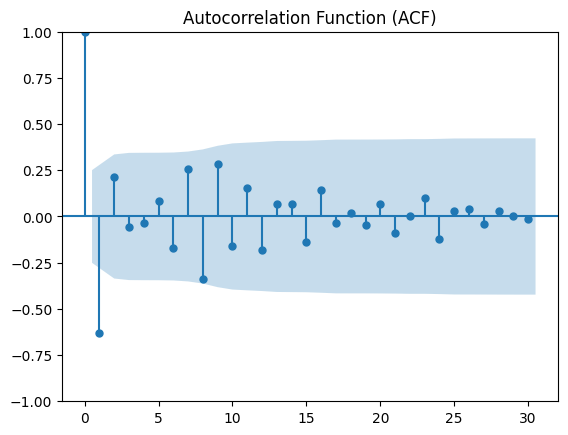

<Figure size 1200x600 with 0 Axes>

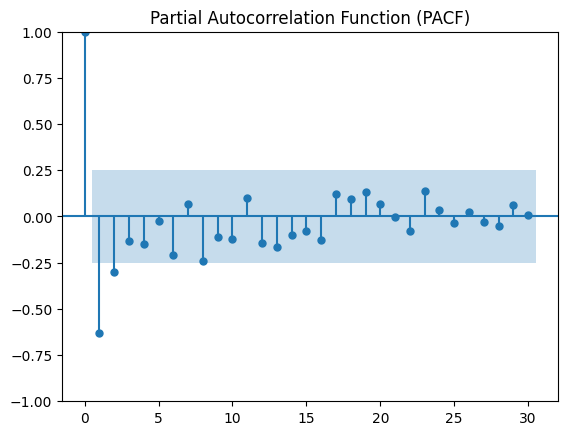


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   62
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -448.182
Date:                Mon, 14 Apr 2025   AIC                            906.364
Time:                        14:53:18   BIC                            916.918
Sample:                             0   HQIC                           910.500
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3229      0.654     -0.493      0.622      -1.605       0.960
ar.L2          0.3020      0.358      0.843      0.399      -0.400       1.0

<Figure size 1200x600 with 0 Axes>

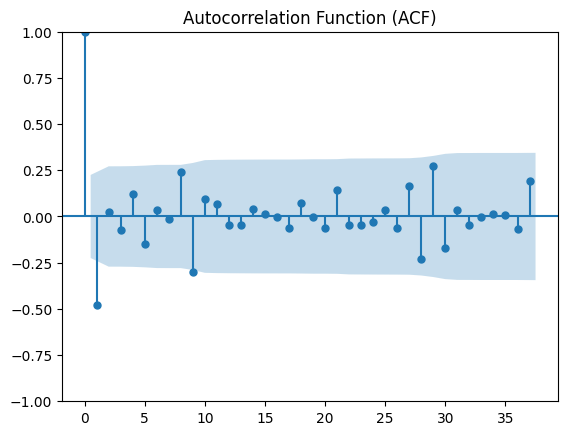

<Figure size 1200x600 with 0 Axes>

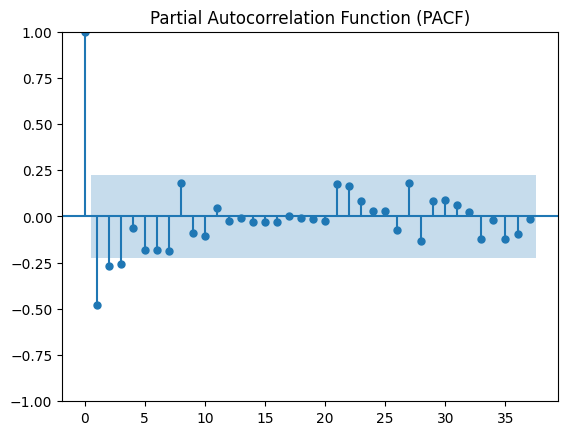


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   77
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -443.071
Date:                Mon, 14 Apr 2025   AIC                            900.143
Time:                        14:53:21   BIC                            916.458
Sample:                             0   HQIC                           906.663
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1610      0.348     -0.463      0.644      -0.843       0.521
ar.L2         -0.9215      0.138     -6.676      0.000      -1.192      -0.6

<Figure size 1200x600 with 0 Axes>

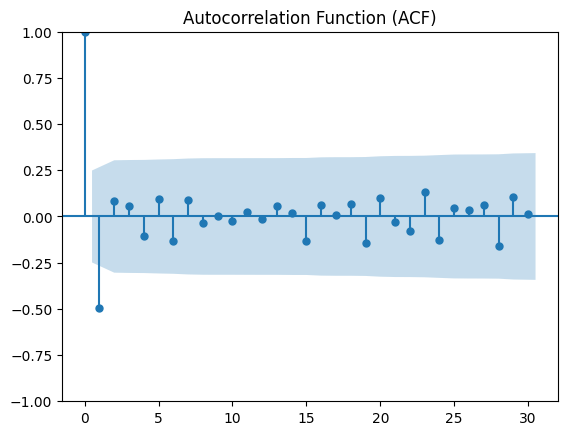

<Figure size 1200x600 with 0 Axes>

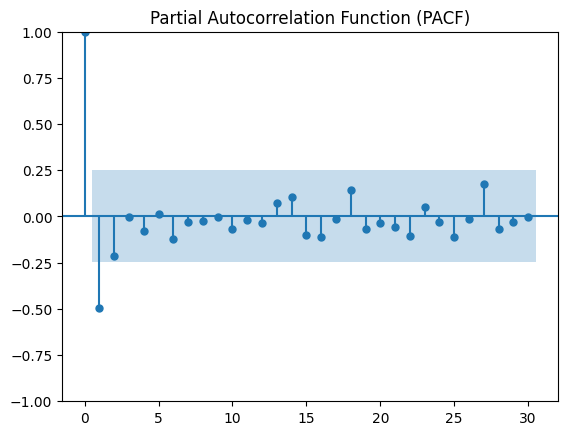


Fitting ARIMA model with order (5, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   63
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -523.989
Date:                Mon, 14 Apr 2025   AIC                           1061.978
Time:                        14:53:25   BIC                           1076.868
Sample:                             0   HQIC                          1067.824
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3945      0.179      2.201      0.028       0.043       0.746
ar.L2          0.0482      0.127      0.378      0.706      -0.202       0.2

<Figure size 1200x600 with 0 Axes>

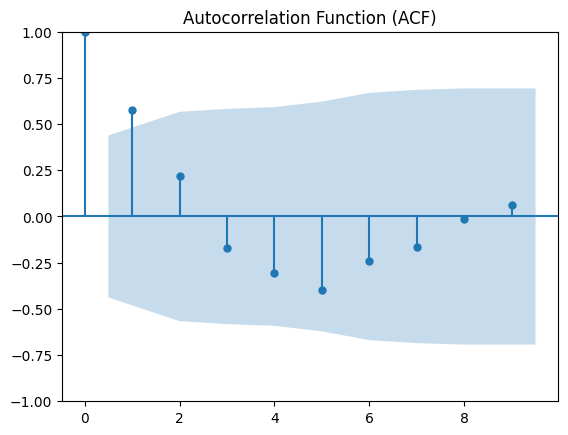

<Figure size 1200x600 with 0 Axes>

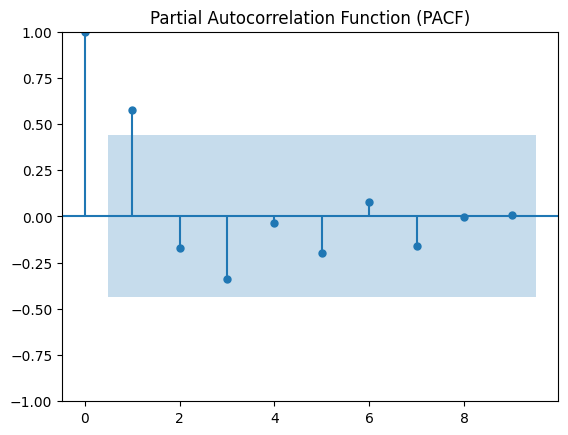


Fitting ARIMA model with order (3, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   20
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -156.230
Date:                Mon, 14 Apr 2025   AIC                            326.461
Time:                        14:53:29   BIC                            333.431
Sample:                             0   HQIC                           327.822
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3281.0247    103.141     31.811      0.000    3078.872    3483.177
ar.L1          0.8291      0.70

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ગુલાબ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_425188585584291e417574f3b7bc9ade.pkl
Model for ગુલાબ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_425188585584291e417574f3b7bc9ade.pkl
આબલી size:  4
False
Checking stationarity for the raw price data of આબલી:

ADF Test Results:
ADF Statistic: 0.0207
p-value: 0.9602
Critical Value 1%: -10.4172
Critical Value 5%: -5.7784
Critical Value 10%: -3.3917
The series is not stationary (differencing is required).
Data is stationary with d=1.

Checking stationarity for the differenced data:
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 1 at lags [1]


<Figure size 1200x600 with 0 Axes>

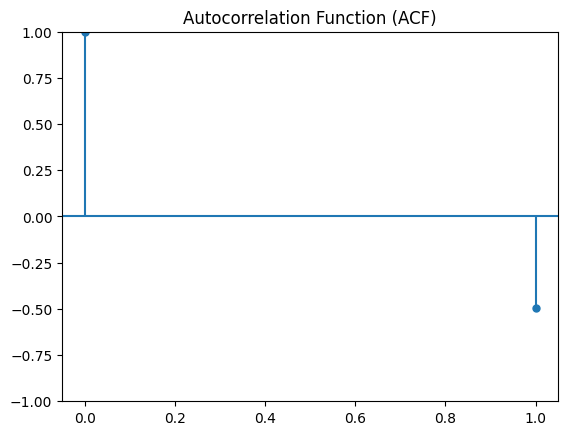

<Figure size 1200x600 with 0 Axes>

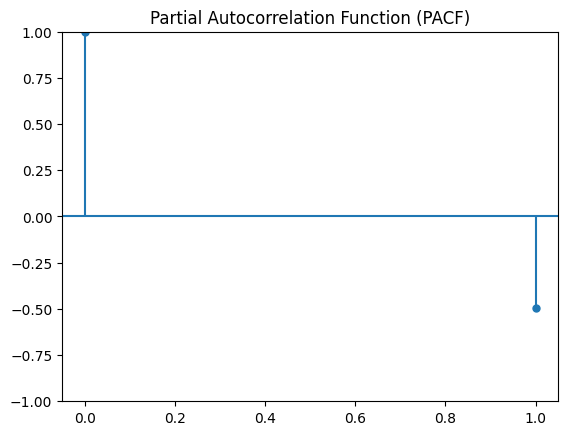


Fitting ARIMA model with order (1, 1, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    4
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -29.489
Date:                Mon, 14 Apr 2025   AIC                             62.978
Time:                        14:53:31   BIC                             61.175
Sample:                             0   HQIC                            59.354
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0993      0.825      0.120      0.904      -1.517       1.716
sigma2      2.414e+07   3.24e-0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for આબલી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_e9eb4c7cf9402b51e44b98141f351c8b.pkl
Model for આબલી saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_e9eb4c7cf9402b51e44b98141f351c8b.pkl
મોસંબી size:  77
True
Checking stationarity for the raw price data of મોસંબી:

ADF Test Results:
ADF Statistic: -2.0325
p-value: 0.2725
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.6081
p-value: 0.0000
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.6081
p-value: 0.0000
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is stationary (no further differencing needed).
Signif

<Figure size 1200x600 with 0 Axes>

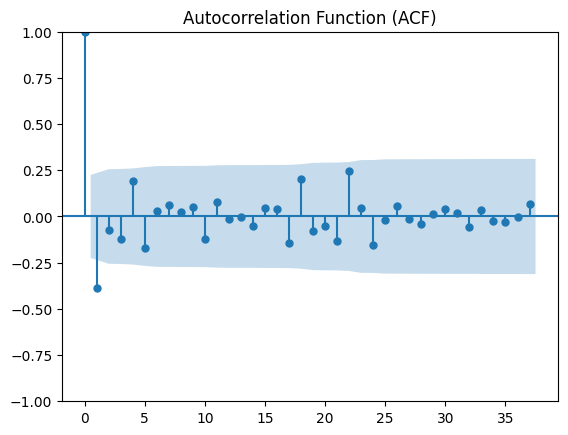

<Figure size 1200x600 with 0 Axes>

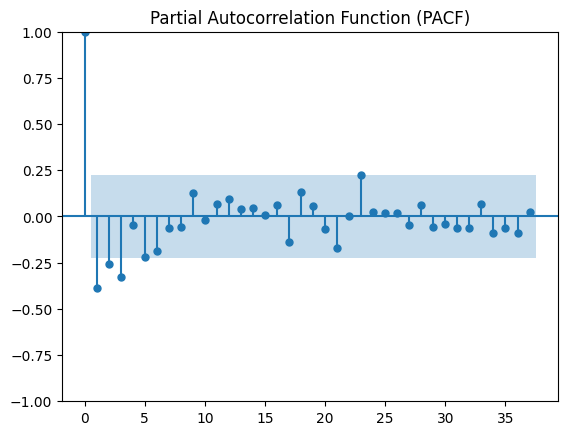


Fitting ARIMA model with order (3, 1, 3)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   77
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -451.450
Date:                Mon, 14 Apr 2025   AIC                            916.900
Time:                        14:53:33   BIC                            933.215
Sample:                             0   HQIC                           923.420
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0567      0.367     -2.875      0.004      -1.777      -0.336
ar.L2         -0.5388      0.27

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મોસંબી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_cc66f34e621f8e404ad44b9a978ea2fd.pkl
Model for મોસંબી saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_cc66f34e621f8e404ad44b9a978ea2fd.pkl
ટેટી size:  111
True
Checking stationarity for the raw price data of ટેટી:

ADF Test Results:
ADF Statistic: -1.2330
p-value: 0.6592
Critical Value 1%: -3.4936
Critical Value 5%: -2.8892
Critical Value 10%: -2.5815
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.7235
p-value: 0.0001
Critical Value 1%: -3.4989
Critical Value 5%: -2.8915
Critical Value 10%: -2.5828
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7235
p-value: 0.0001
Critical Value 1%: -3.4989
Critical Value 5%: -2.8915
Critical Value 10%: -2.5828
The series is stationary (no further differencing needed).
Signi

<Figure size 1200x600 with 0 Axes>

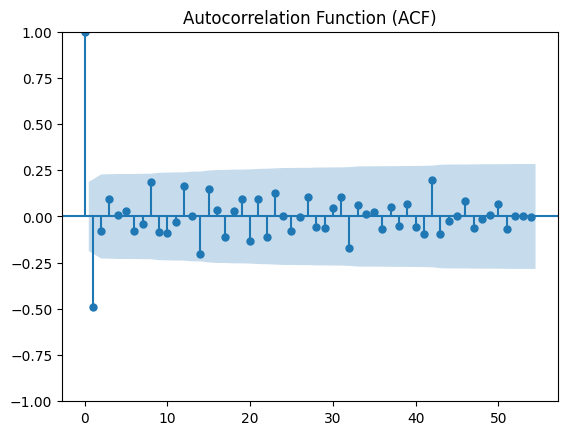

<Figure size 1200x600 with 0 Axes>

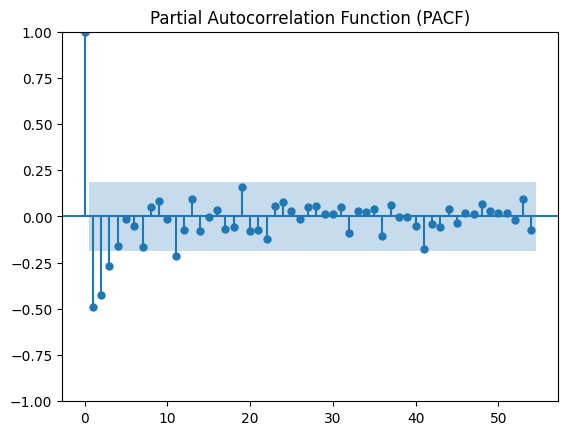


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  111
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -636.577
Date:                Mon, 14 Apr 2025   AIC                           1287.155
Time:                        14:53:37   BIC                           1306.058
Sample:                             0   HQIC                          1294.822
                                - 111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0345      0.187      0.184      0.854      -0.332       0.401
ar.L2         -0.8707      0.120     -7.269      0.000      -1.105      -0.6

<Figure size 1200x600 with 0 Axes>

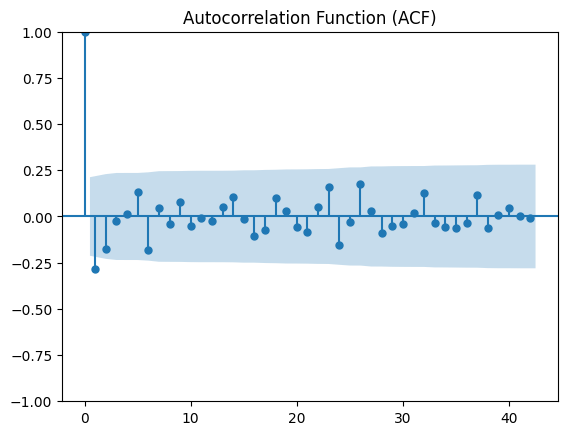

<Figure size 1200x600 with 0 Axes>

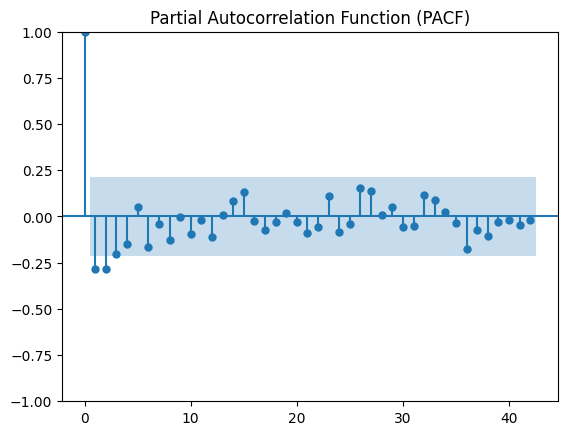


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -549.224
Date:                Mon, 14 Apr 2025   AIC                           1112.447
Time:                        14:53:42   BIC                           1129.546
Sample:                             0   HQIC                          1119.325
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1054      0.190     -5.810      0.000      -1.478      -0.733
ar.L2         -0.5508      0.290     -1.902      0.057      -1.118       0.0

<Figure size 1200x600 with 0 Axes>

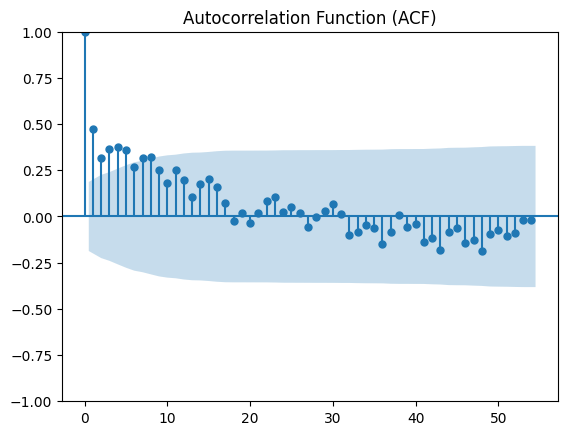

<Figure size 1200x600 with 0 Axes>

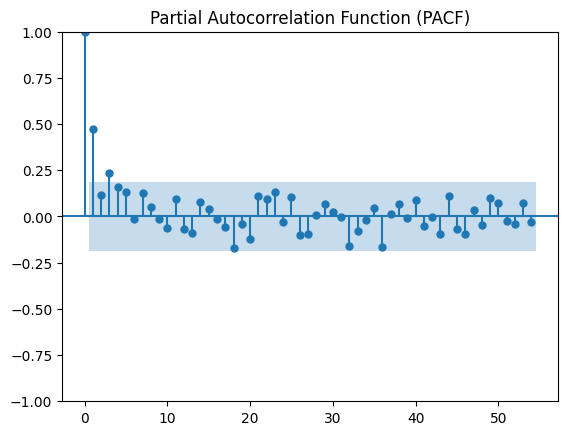


Fitting ARIMA model with order (3, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -829.302
Date:                Mon, 14 Apr 2025   AIC                           1668.605
Time:                        14:53:46   BIC                           1682.107
Sample:                             0   HQIC                          1674.081
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1487.8688   1669.767      0.891      0.373   -1784.814    4760.552
ar.L1          0.7852      0.049     16.128      0.000       0.690       0.8

<Figure size 1200x600 with 0 Axes>

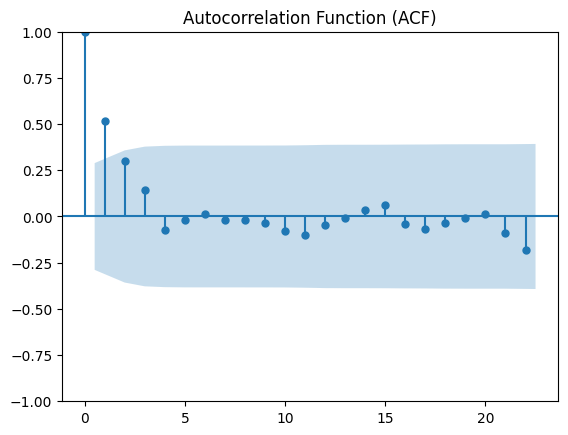

<Figure size 1200x600 with 0 Axes>

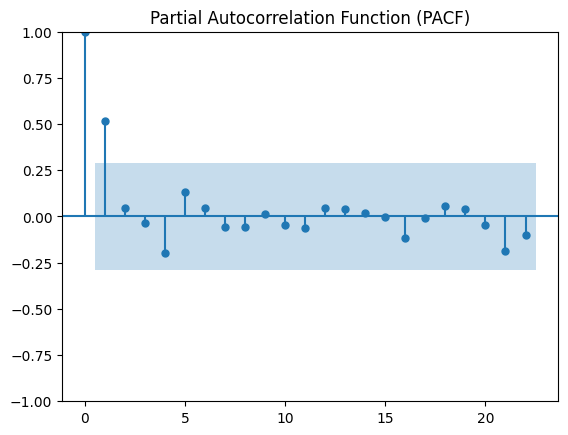


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   46
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -363.045
Date:                Mon, 14 Apr 2025   AIC                            734.090
Time:                        14:53:49   BIC                            741.404
Sample:                             0   HQIC                           736.830
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5289.1303    232.212     22.777      0.000    4834.004    5744.257
ar.L1          0.4977      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for કીવી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_287621d74b02a105769fcb121efef0f6.pkl
Model for કીવી saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_287621d74b02a105769fcb121efef0f6.pkl
અનાનસ size:  4
False
Checking stationarity for the raw price data of અનાનસ:

ADF Test Results:
ADF Statistic: -1.7321
p-value: 0.4147
Critical Value 1%: -10.4172
Critical Value 5%: -5.7784
Critical Value 10%: -3.3917
The series is not stationary (differencing is required).
Data is stationary with d=1.

Checking stationarity for the differenced data:
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


<Figure size 1200x600 with 0 Axes>

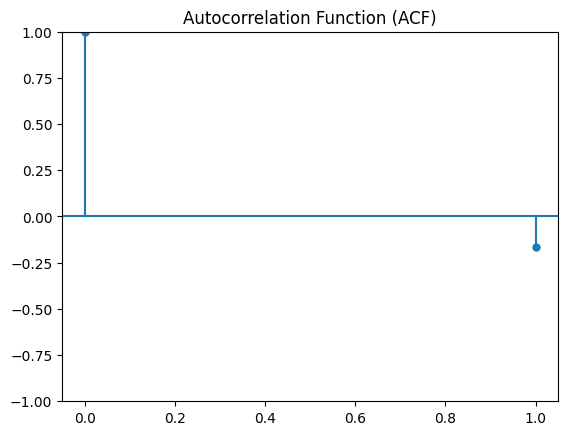

<Figure size 1200x600 with 0 Axes>

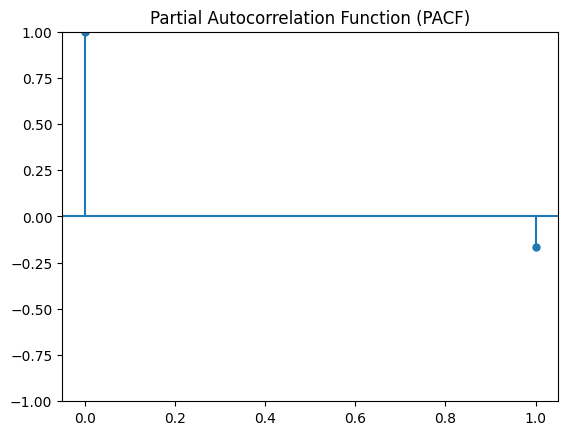


Fitting ARIMA model with order (0, 1, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    4
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -17.464
Date:                Mon, 14 Apr 2025   AIC                             36.928
Time:                        14:53:51   BIC                             36.027
Sample:                             0   HQIC                            35.116
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6666.4187   1.09e+04      0.612      0.540   -1.47e+04     2.8e+04
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for અનાનસ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_100bdc7c160cbdb4295a7b9fa243e26a.pkl
Model for અનાનસ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_100bdc7c160cbdb4295a7b9fa243e26a.pkl
લિચી size:  2
ઓરેંજ size:  1
હાફુસ કેરી size:  32
True
Checking stationarity for the raw price data of હાફુસ કેરી:

ADF Test Results:
ADF Statistic: -0.4926
p-value: 0.8934
Critical Value 1%: -3.7112
Critical Value 5%: -2.9812
Critical Value 10%: -2.6301
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.9408
p-value: 0.0000
Critical Value 1%: -3.7112
Critical Value 5%: -2.9812
Critical Value 10%: -2.6301
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.9408
p-value: 0.0000
Critical Value 1%: -3.7112
Critical Value 5%: -2.9812
Critical Value 10%: -2.6301
The series is stationary (

<Figure size 1200x600 with 0 Axes>

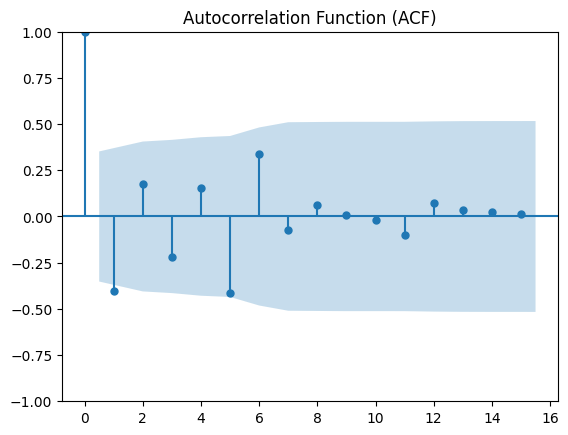

<Figure size 1200x600 with 0 Axes>

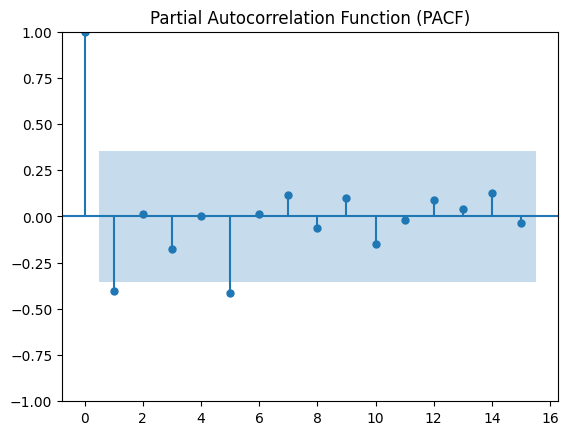


Fitting ARIMA model with order (4, 1, 3)...
ARIMA model fitted successfully!

ARIMA Model Summary:


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   32
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -255.408
Date:                Mon, 14 Apr 2025   AIC                            526.816
Time:                        14:53:53   BIC                            538.288
Sample:                             0   HQIC                           530.555
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7460      0.326     -2.287      0.022      -1.385      -0.107
ar.L2          0.1860      0.530      0.351      0.726      -0.853       1.225
ar.L3          0.7167      0.484      1.480      0.1

<Figure size 1200x600 with 0 Axes>

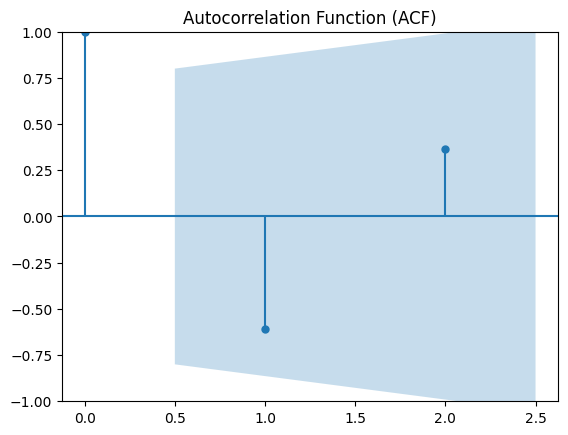

<Figure size 1200x600 with 0 Axes>

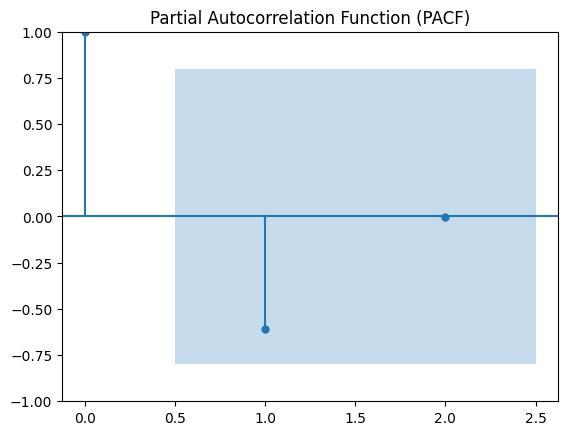


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.371
Date:                Mon, 14 Apr 2025   AIC                            102.742
Time:                        14:53:56   BIC                            102.117
Sample:                             0   HQIC                           100.241
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0465      1.109     -0.042      0.967      -2.219       2.126
ma.L1         -1.0000      1.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for લાલબાગ કેરી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_bd14fb01213332e76677dd9973ba9efa.pkl
Model for લાલબાગ કેરી saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_bd14fb01213332e76677dd9973ba9efa.pkl
બદામ કેરી size:  11
True
Checking stationarity for the raw price data of બદામ કેરી:

ADF Test Results:
ADF Statistic: -2.2499
p-value: 0.1886
Critical Value 1%: -4.3316
Critical Value 5%: -3.2330
Critical Value 10%: -2.7487
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.6254
p-value: 0.0879
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -3.0543
p-value: 0.0301
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differ

<Figure size 1200x600 with 0 Axes>

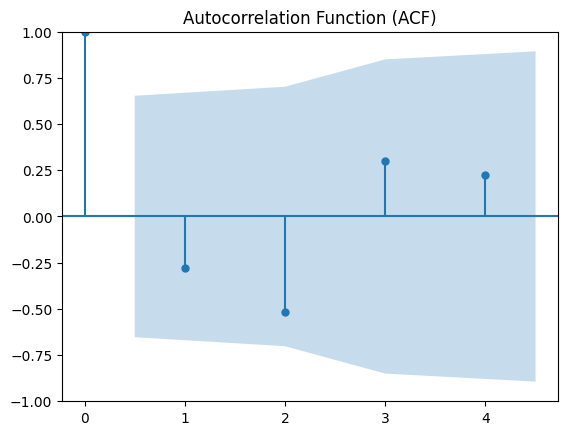

<Figure size 1200x600 with 0 Axes>

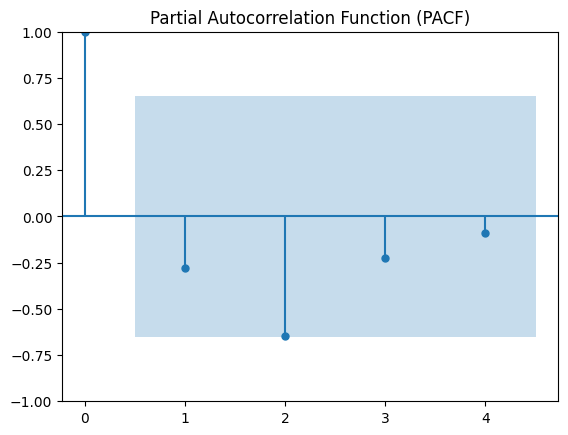


Fitting ARIMA model with order (2, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   11
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 -71.002
Date:                Mon, 14 Apr 2025   AIC                            150.004
Time:                        14:53:58   BIC                            150.793
Sample:                             0   HQIC                           148.302
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5420      0.344     -1.577      0.115      -1.216       0.132
ar.L2         -0.7989      0.18

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for બદામ કેરી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_46daf60519d107dba885afbf32a83114.pkl
Model for બદામ કેરી saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_46daf60519d107dba885afbf32a83114.pkl
સૂ્દરી કેરી size:  2
કેસર કેરી size:  25
True
Checking stationarity for the raw price data of કેસર કેરી:

ADF Test Results:
ADF Statistic: -2.2605
p-value: 0.1850
Critical Value 1%: -3.7377
Critical Value 5%: -2.9922
Critical Value 10%: -2.6357
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.4185
p-value: 0.0000
Critical Value 1%: -3.7884
Critical Value 5%: -3.0131
Critical Value 10%: -2.6464
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -5.4185
p-value: 0.0000
Critical Value 1%: -3.7884
Critical Value 5%: -3.0131
Critical Value 10%: -2.6464
The series is stationary (no

<Figure size 1200x600 with 0 Axes>

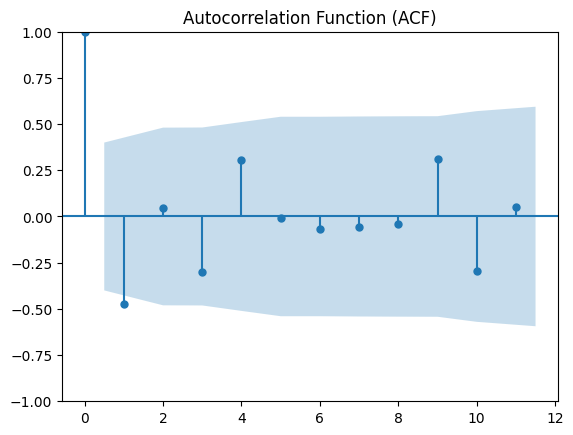

<Figure size 1200x600 with 0 Axes>

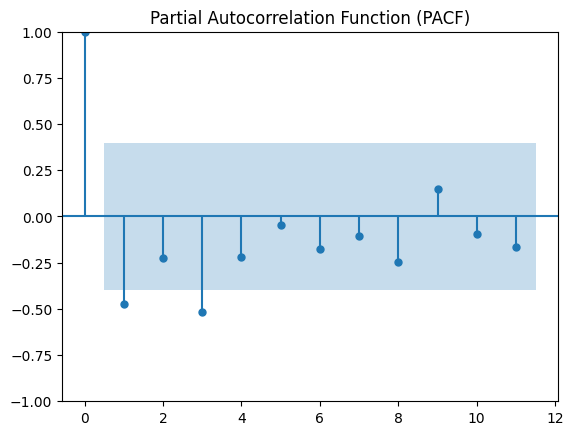


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   25
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -197.083
Date:                Mon, 14 Apr 2025   AIC                            408.166
Time:                        14:54:01   BIC                            416.412
Sample:                             0   HQIC                           410.353
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3274      0.389     -0.841      0.400      -1.091       0.436
ar.L2         -0.8385      0.145     -5.782      0.000      -1.123      -0.5

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
import boto3
import io
from dotenv import load_dotenv
load_dotenv()


###------------------------------------------------------------------------------------------------------------------------------
# Setup your DigitalOcean Spaces client
def get_spaces_client():
    return boto3.client(
        's3',
        region_name=os.getenv("SPACES_REGION"),
        endpoint_url=os.getenv("SPACES_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("SPACES_ACCESS_KEY"),
        aws_secret_access_key=os.getenv("SPACES_SECRET_KEY")
    )

def dump_model_to_spaces(model, product, category):
    try:
        # Prepare filename
        hashed_name = safe_filename(product)
        filename = f"arima_model_{hashed_name}.pkl"
        key = f"ml_models/{category}/{filename}"  # e.g., ml_models/fruits_saved_models/arima_model_apple.pkl
        bucket = os.getenv("SPACES_BUCKET_NAME")
        print(f"Uploading to bucket: {bucket} with key: {key}")

        # Serialize model to bytes
        bytes_buffer = io.BytesIO()
        joblib.dump(model, bytes_buffer)
        bytes_buffer.seek(0)

        # Upload to Spaces
        client = get_spaces_client()
        client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=bytes_buffer)

        print(f"Model for {product} uploaded to Spaces at {key}")
    except Exception as e:
        print(f"Error uploading model for {product} to Spaces: {e}")
        

def filterData(existing_data):
    data = existing_data
    
    # Get current date and calculate the cutoff date (4 months ago)
    current_date = datetime.today()
    cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
    cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

    # today_date = datetime.now().strftime("%d/%m/%Y")

    # Filter data to keep only the last 4 months
    filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]
    
    return filtered_data


def append_csv_to_spaces(new_df: pd.DataFrame, filename: str):
    client = get_spaces_client()
    key = f"data/fruits/{filename}"

    try:
        # Step 1: Download existing file if it exists
        existing = client.get_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key)
        existing_data = pd.read_csv(existing['Body'])
        print("📥 Existing CSV loaded from Spaces.")
        
        if(filename == "fruits_price_data.csv"):
            existing_data = filterData(existing_data)
            

        # Step 2: Append new data
        combined_df = pd.concat([existing_data, new_df], ignore_index=True)

    except client.exceptions.NoSuchKey:
        print("ℹ️ No existing file found. Creating a new one.")
        combined_df = new_df

    # Step 3: Upload updated CSV
    csv_buffer = io.StringIO()
    combined_df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=csv_buffer.getvalue())

    print(f"✅ CSV saved to Spaces at {key}")



products_with_boxcox = []
### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/fruits/fruits_price_data.csv"


# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/fruits_saved_models"
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
allYearsFilename = base_dir / "data/fruits/fruits_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)
        
        
        columns = ["Date", "Some Extra Column", "Item Name", "Low Price", "Average Price", "High Price"]
        new_df = pd.DataFrame(data, columns=columns)
        print("Before dropping the column:")
        print(new_df.head())
        

        # Drop the column at index 1 (which corresponds to "Item Name")
        new_df.drop(new_df.columns[1], axis=1, inplace=True)
        
        print("\nAfter dropping the column:")
        print(new_df.head())
        
        new_df['Average Price'], new_df['High Price'] = new_df['High Price'], new_df['Average Price']

        # Print the new DataFrame to verify
        print("\nAfter rearranging the column:")
        print(new_df.head())


        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        append_csv_to_spaces(new_df, "fruits_price_data.csv")
        write_to_csv(data, allYearsFilename)
        append_csv_to_spaces(new_df, "fruits_price_data-all_years.csv")
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("FRUITS_WEBPAGE_PATH"),
                                           os.getenv("FRUITS_DATE_PATH"),
                                           os.getenv("FRUITS_SUBMIT_BUTTON_PATH"),
                                           os.getenv("FRUITS_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            dump_model_to_spaces(model_fit, product, "fruits_saved_models")
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()


# TEMP

         Date Item Name  Low Price  Average Price  High Price
0  13-12-2024     જામફળ        400            700        1000
1  13-12-2024      દાડમ        500           1050        1600
2  13-12-2024     સફરજન       1000           2300        3600
3  13-12-2024      ચીકુ        600            800        1000
4  13-12-2024    પોપૈયા        500            550         600
['જામફળ' 'દાડમ' 'સફરજન' 'ચીકુ' 'પોપૈયા' 'સીતાફળ' 'કેળા' 'સંતરા' 'તરબૂચ'
 'સ્ટ્રોબેરી' 'માલટા' 'ક્મલમ' 'ગુલાબ' 'આબલી' 'મોસંબી' 'ટેટી' 'બોર'
 'દ્રાક્ષ' 'આલુચા' 'કીવી' 'અનાનસ' 'લિચી' 'ઓરેંજ' 'હાફુસ કેરી'
 'લાલબાગ કેરી' 'બદામ કેરી' 'સૂ્દરી કેરી' 'કેસર કેરી' 'તોતાપુરી કેરી']
Data older than 13-12-2024 has been removed.
Before dropping the column:
         Date Some Extra Column Item Name Low Price Average Price High Price
0  12-04-2025                 1     જામફળ       200           400        300
1  12-04-2025                 2      દાડમ       600          1500       1050
2  12-04-2025                 3     સફરજન      1600  

<Figure size 1200x600 with 0 Axes>

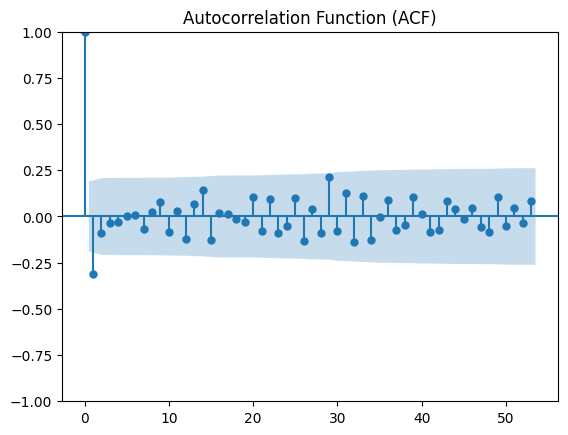

<Figure size 1200x600 with 0 Axes>

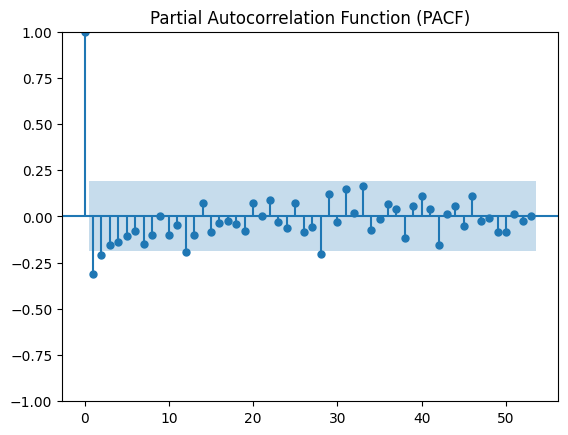


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  108
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -672.639
Date:                Sat, 12 Apr 2025   AIC                           1359.279
Time:                        15:31:59   BIC                           1377.989
Sample:                             0   HQIC                          1366.864
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7025      0.174     -4.048      0.000      -1.043      -0.362
ar.L2         -0.4932      0.211     -2.334      0.020      -0.907      -0.0

<Figure size 1200x600 with 0 Axes>

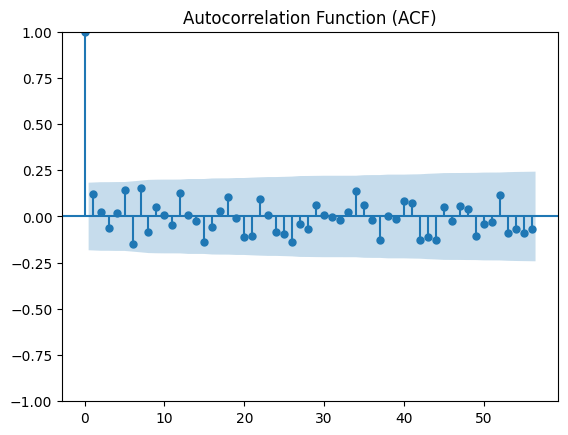

<Figure size 1200x600 with 0 Axes>

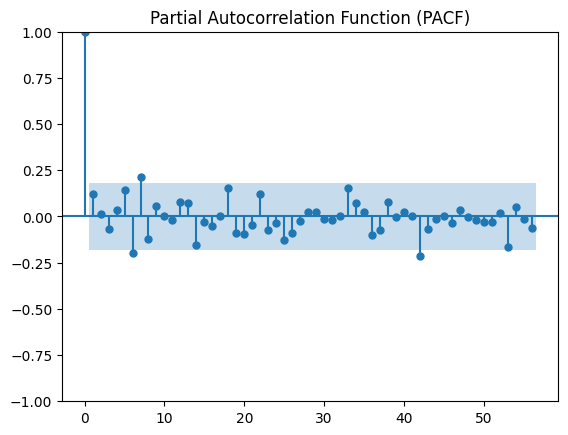


Fitting ARIMA model with order (5, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  115
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -783.340
Date:                Sat, 12 Apr 2025   AIC                           1586.680
Time:                        15:32:03   BIC                           1614.129
Sample:                             0   HQIC                          1597.821
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1112.6147     30.356     36.653      0.000    1053.119    1172.110
ar.L1         -1.7114      0.204     -8.389      0.000      -2.111      -1.3

<Figure size 1200x600 with 0 Axes>

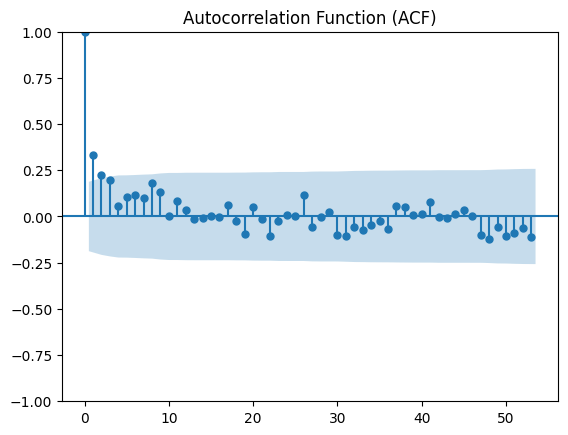

<Figure size 1200x600 with 0 Axes>

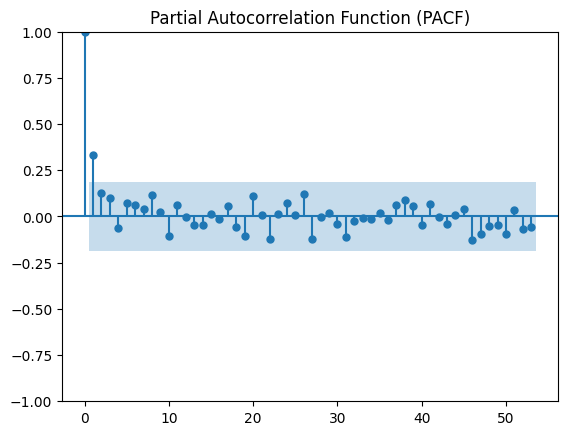


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -773.230
Date:                Sat, 12 Apr 2025   AIC                           1554.459
Time:                        15:32:07   BIC                           1565.225
Sample:                             0   HQIC                          1558.825
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2193.0275     47.663     46.011      0.000    2099.610    2286.445
ar.L1          0.2893      0.09

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સફરજન uploaded to Spaces at ml_models/fruits_saved_models/arima_model_af53e0d54a1037dd6713b287013502b8.pkl
ચીકુ size:  98
False
Checking stationarity for the raw price data of ચીકુ:

ADF Test Results:
ADF Statistic: -4.7700
p-value: 0.0001
Critical Value 1%: -3.4996
Critical Value 5%: -2.8918
Critical Value 10%: -2.5829
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7700
p-value: 0.0001
Critical Value 1%: -3.4996
Critical Value 5%: -2.8918
Critical Value 10%: -2.5829
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 3 at lags [13 15 16]


<Figure size 1200x600 with 0 Axes>

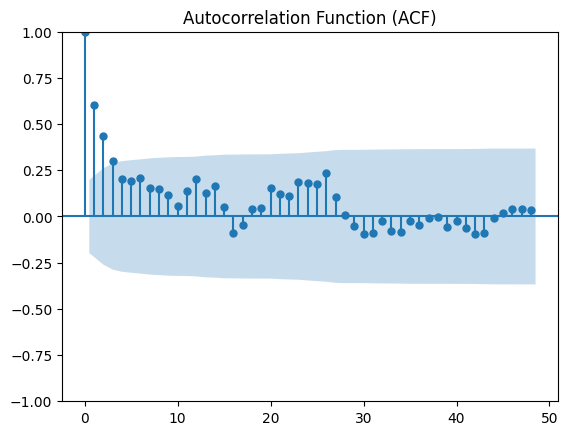

<Figure size 1200x600 with 0 Axes>

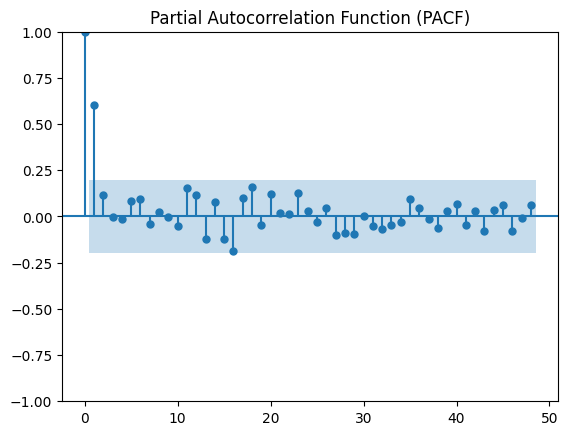


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   98
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -603.473
Date:                Sat, 12 Apr 2025   AIC                           1216.947
Time:                        15:32:10   BIC                           1229.872
Sample:                             0   HQIC                          1222.175
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        670.2129     35.838     18.701      0.000     599.972     740.454
ar.L1          0.5316      0.10

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ચીકુ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_3da490d055119f2d5fa18ff29a9c3ef6.pkl
પોપૈયા size:  65
False
Checking stationarity for the raw price data of પોપૈયા:

ADF Test Results:
ADF Statistic: -2.8502
p-value: 0.0514
Critical Value 1%: -3.5387
Critical Value 5%: -2.9086
Critical Value 10%: -2.5919
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -9.6136
p-value: 0.0000
Critical Value 1%: -3.5405
Critical Value 5%: -2.9094
Critical Value 10%: -2.5923
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -9.6136
p-value: 0.0000
Critical Value 1%: -3.5405
Critical Value 5%: -2.9094
Critical Value 10%: -2.5923
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [ 1  6  8 10]
Significant spikes in PACF (p): 8 at lags [ 1  2  4  6  8 10 14 18]


<Figure size 1200x600 with 0 Axes>

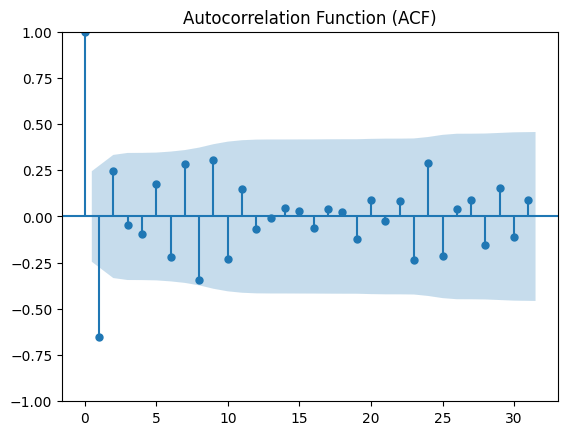

<Figure size 1200x600 with 0 Axes>

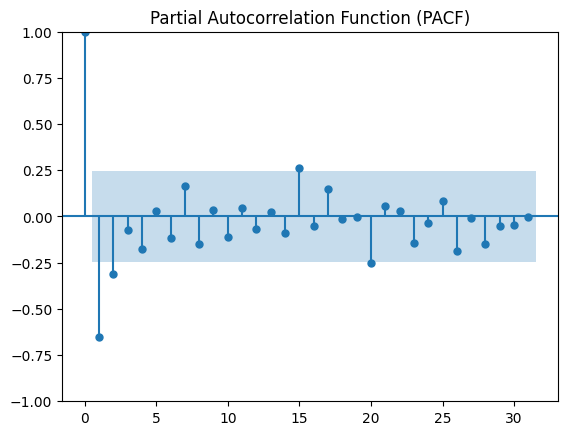


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   65
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -379.619
Date:                Sat, 12 Apr 2025   AIC                            777.237
Time:                        15:32:13   BIC                            796.667
Sample:                             0   HQIC                           784.892
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1785      8.617     -0.253      0.800     -19.068      14.711
ar.L2         -1.5320     18.021     -0.085      0.932     -36.852      33.7

<Figure size 1200x600 with 0 Axes>

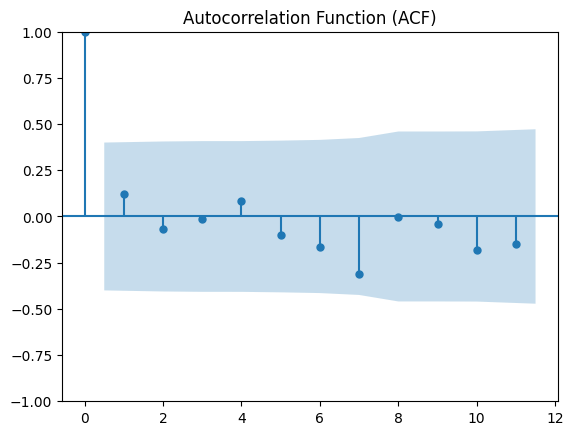

<Figure size 1200x600 with 0 Axes>

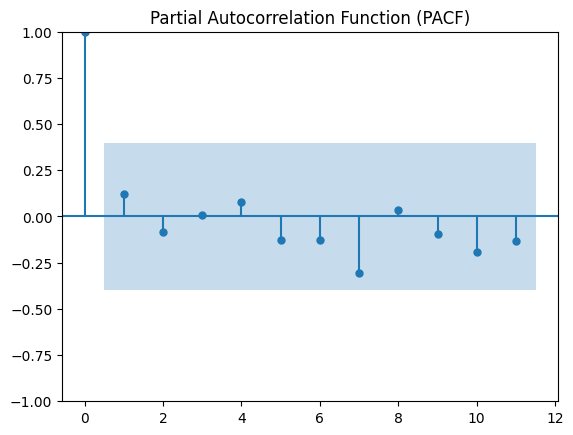


Fitting ARIMA model with order (3, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -154.867
Date:                Sat, 12 Apr 2025   AIC                            321.735
Time:                        15:32:17   BIC                            328.803
Sample:                             0   HQIC                           323.610
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        790.1624     32.453     24.348      0.000     726.557     853.768
ar.L1         -0.7334      0.307     -2.393      0.017      -1.334      -0.1

<Figure size 1200x600 with 0 Axes>

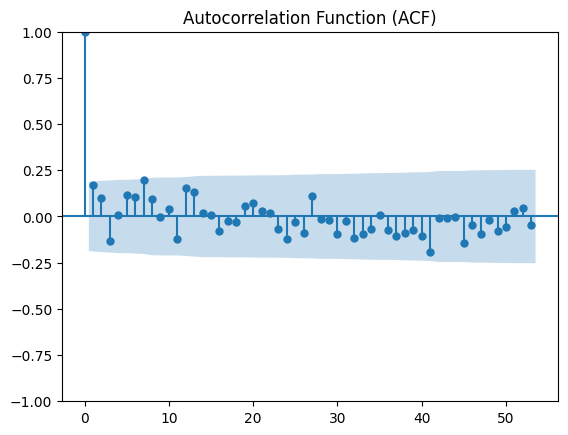

<Figure size 1200x600 with 0 Axes>

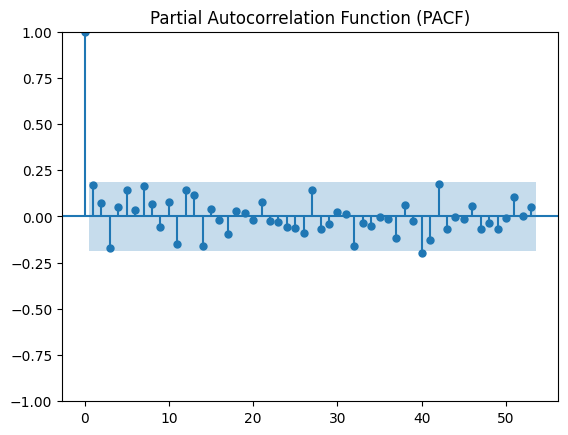


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -494.777
Date:                Sat, 12 Apr 2025   AIC                           1005.554
Time:                        15:32:20   BIC                           1027.084
Sample:                             0   HQIC                          1014.285
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        505.2625      3.060    165.115      0.000     499.265     511.260
ar.L1         -1.1334      0.176     -6.451      0.000      -1.478      -0.7

<Figure size 1200x600 with 0 Axes>

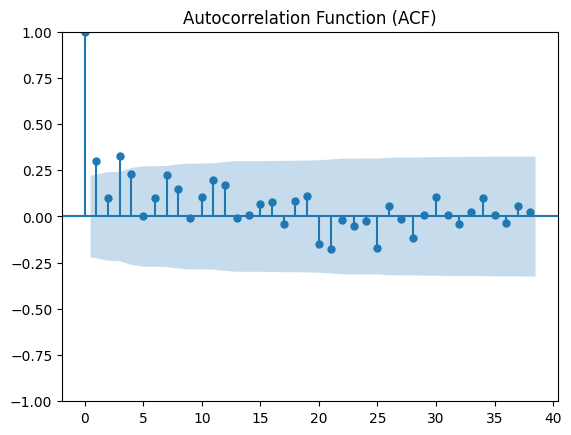

<Figure size 1200x600 with 0 Axes>

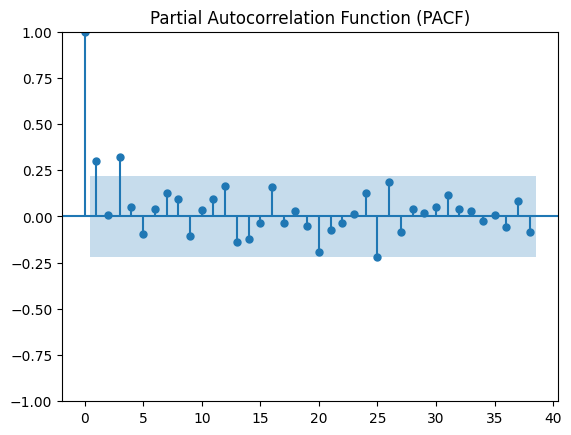


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -605.694
Date:                Sat, 12 Apr 2025   AIC                           1221.387
Time:                        15:32:23   BIC                           1233.234
Sample:                             0   HQIC                          1226.133
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1090.6329    127.938      8.525      0.000     839.878    1341.388
ar.L1          0.2225      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સંતરા uploaded to Spaces at ml_models/fruits_saved_models/arima_model_e5e4f6100a26c314e26a8cc71e15096d.pkl
તરબૂચ size:  95
False
Checking stationarity for the raw price data of તરબૂચ:

ADF Test Results:
ADF Statistic: -1.4811
p-value: 0.5429
Critical Value 1%: -3.5035
Critical Value 5%: -2.8935
Critical Value 10%: -2.5838
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -10.8103
p-value: 0.0000
Critical Value 1%: -3.5035
Critical Value 5%: -2.8935
Critical Value 10%: -2.5838
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -10.8103
p-value: 0.0000
Critical Value 1%: -3.5035
Critical Value 5%: -2.8935
Critical Value 10%: -2.5838
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 6 at lags [ 1  2  4  7 12 17]


<Figure size 1200x600 with 0 Axes>

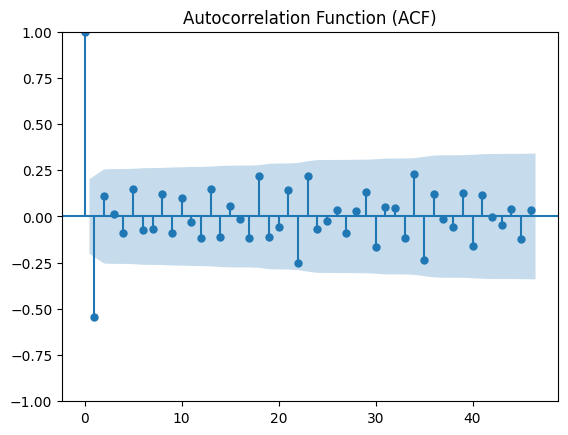

<Figure size 1200x600 with 0 Axes>

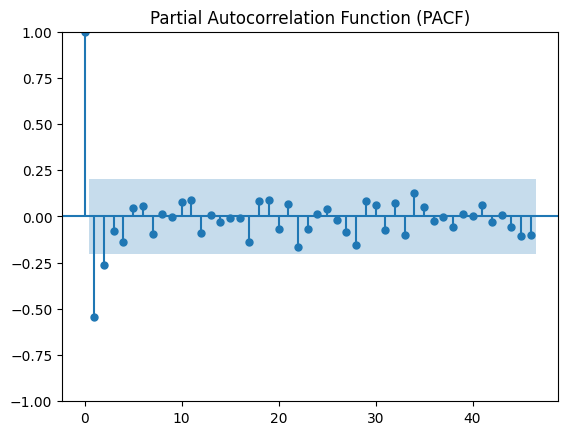


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   95
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -431.799
Date:                Sat, 12 Apr 2025   AIC                            869.598
Time:                        15:32:30   BIC                            877.228
Sample:                             0   HQIC                           872.680
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2309      0.154     -1.496      0.135      -0.533       0.072
ma.L1         -0.4739      0.14

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તરબૂચ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_7d0556adae3db00e807d8d48a94d171c.pkl
સ્ટ્રોબેરી size:  62
True
Checking stationarity for the raw price data of સ્ટ્રોબેરી:

ADF Test Results:
ADF Statistic: -1.5712
p-value: 0.4980
Critical Value 1%: -3.5464
Critical Value 5%: -2.9119
Critical Value 10%: -2.5937
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -9.1881
p-value: 0.0000
Critical Value 1%: -3.5464
Critical Value 5%: -2.9119
Critical Value 10%: -2.5937
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -9.1881
p-value: 0.0000
Critical Value 1%: -3.5464
Critical Value 5%: -2.9119
Critical Value 10%: -2.5937
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [1 8]
Significant spikes in PACF (p): 14 at lags [ 1  2  3  4  6  8  9 10 12 13 14 

<Figure size 1200x600 with 0 Axes>

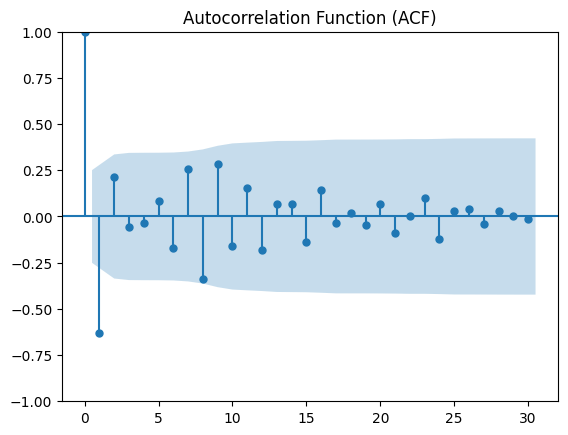

<Figure size 1200x600 with 0 Axes>

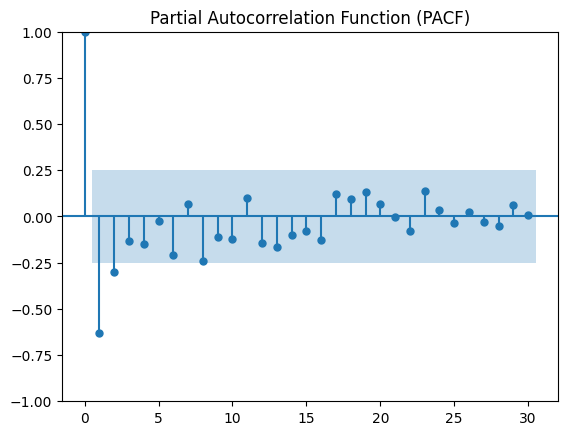


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   62
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -448.182
Date:                Sat, 12 Apr 2025   AIC                            906.364
Time:                        15:32:33   BIC                            916.918
Sample:                             0   HQIC                           910.500
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3229      0.654     -0.493      0.622      -1.605       0.960
ar.L2          0.3020      0.35

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સ્ટ્રોબેરી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_b340a75b315d96d9eab42cda700a56c9.pkl
માલટા size:  77
True
Checking stationarity for the raw price data of માલટા:

ADF Test Results:
ADF Statistic: 0.0770
p-value: 0.9645
Critical Value 1%: -3.5320
Critical Value 5%: -2.9058
Critical Value 10%: -2.5904
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -3.5095
p-value: 0.0077
Critical Value 1%: -3.5320
Critical Value 5%: -2.9058
Critical Value 10%: -2.5904
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.5095
p-value: 0.0077
Critical Value 1%: -3.5320
Critical Value 5%: -2.9058
Critical Value 10%: -2.5904
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [1 5 9]
Significant spikes in PACF (p): 7 at lags [ 1  2  3  5  6  7 10]


<Figure size 1200x600 with 0 Axes>

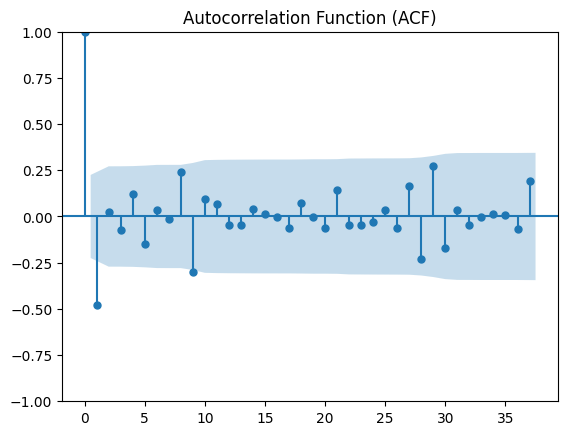

<Figure size 1200x600 with 0 Axes>

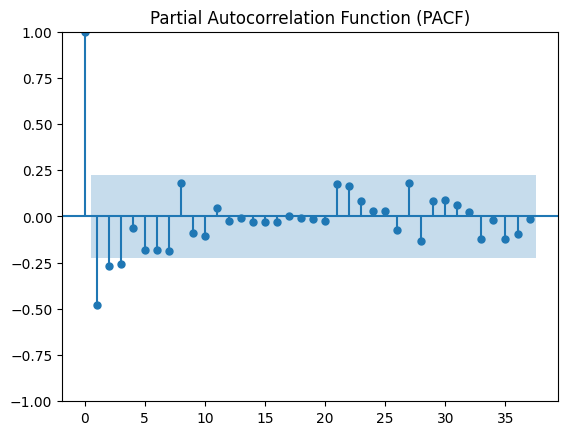


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   77
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -443.071
Date:                Sat, 12 Apr 2025   AIC                            900.143
Time:                        15:32:37   BIC                            916.458
Sample:                             0   HQIC                           906.663
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1610      0.348     -0.463      0.644      -0.843       0.521
ar.L2         -0.9215      0.138     -6.676      0.000      -1.192      -0.6

<Figure size 1200x600 with 0 Axes>

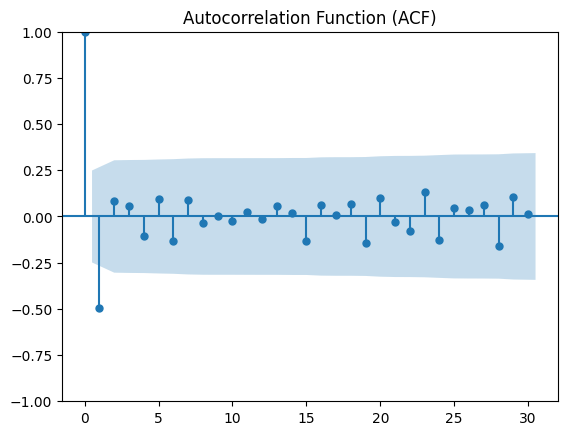

<Figure size 1200x600 with 0 Axes>

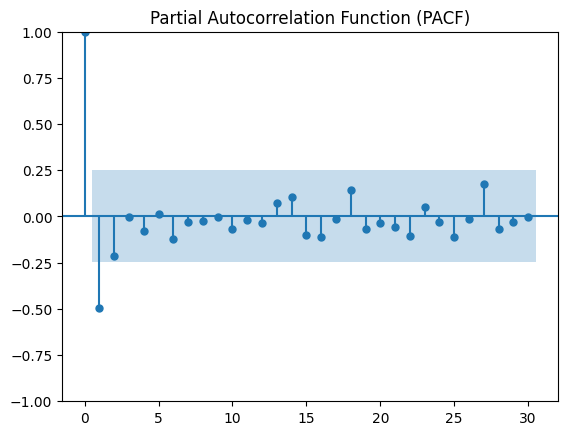


Fitting ARIMA model with order (5, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   63
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -523.989
Date:                Sat, 12 Apr 2025   AIC                           1061.978
Time:                        15:32:42   BIC                           1076.868
Sample:                             0   HQIC                          1067.824
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3945      0.179      2.201      0.028       0.043       0.746
ar.L2          0.0482      0.127      0.378      0.706      -0.202       0.2

<Figure size 1200x600 with 0 Axes>

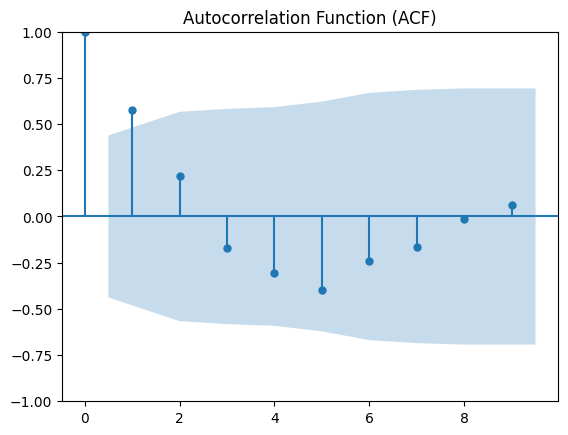

<Figure size 1200x600 with 0 Axes>

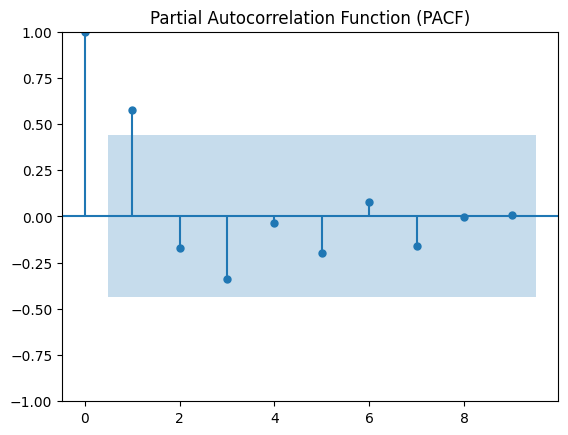


Fitting ARIMA model with order (3, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   20
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -156.230
Date:                Sat, 12 Apr 2025   AIC                            326.461
Time:                        15:32:46   BIC                            333.431
Sample:                             0   HQIC                           327.822
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3281.0247    103.141     31.811      0.000    3078.872    3483.177
ar.L1          0.8291      0.70

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ગુલાબ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_425188585584291e417574f3b7bc9ade.pkl
આબલી size:  4
False
Checking stationarity for the raw price data of આબલી:

ADF Test Results:
ADF Statistic: 0.0207
p-value: 0.9602
Critical Value 1%: -10.4172
Critical Value 5%: -5.7784
Critical Value 10%: -3.3917
The series is not stationary (differencing is required).
Data is stationary with d=1.

Checking stationarity for the differenced data:
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 1 at lags [1]


<Figure size 1200x600 with 0 Axes>

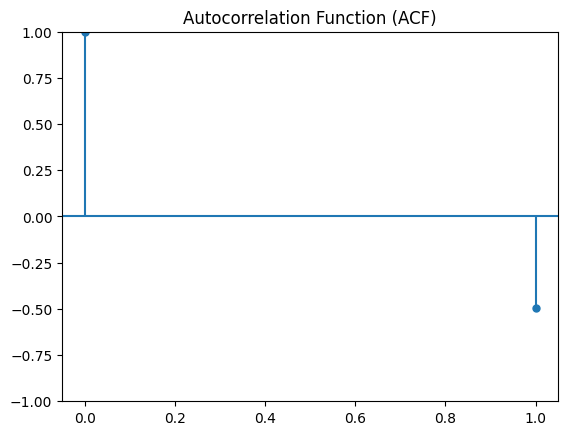

<Figure size 1200x600 with 0 Axes>

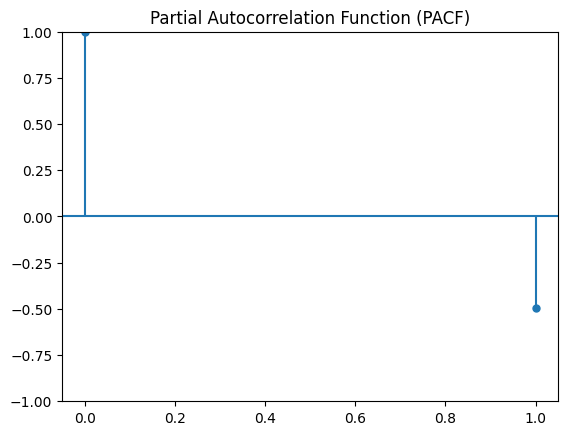


Fitting ARIMA model with order (1, 1, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    4
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -29.489
Date:                Sat, 12 Apr 2025   AIC                             62.978
Time:                        15:32:48   BIC                             61.175
Sample:                             0   HQIC                            59.354
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0993      0.825      0.120      0.904      -1.517       1.716
sigma2      2.414e+07   3.24e-0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for આબલી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_e9eb4c7cf9402b51e44b98141f351c8b.pkl
મોસંબી size:  77
True
Checking stationarity for the raw price data of મોસંબી:

ADF Test Results:
ADF Statistic: -2.0325
p-value: 0.2725
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.6081
p-value: 0.0000
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.6081
p-value: 0.0000
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [ 1  5 17]
Significant spikes in PACF (p): 6 at lags [ 1  2  3  5  6 17]


<Figure size 1200x600 with 0 Axes>

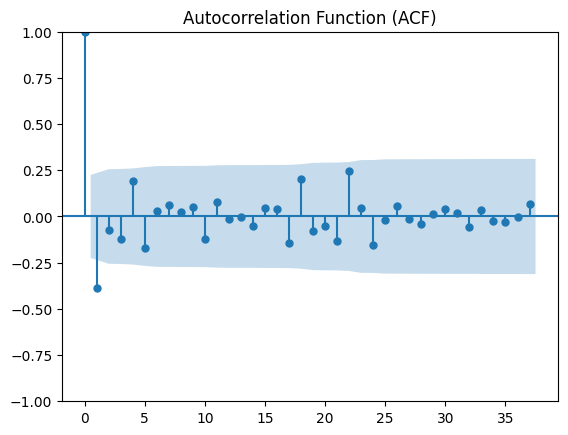

<Figure size 1200x600 with 0 Axes>

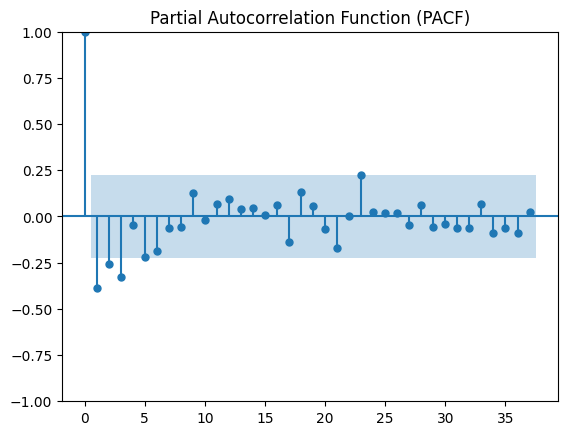


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   77
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -451.450
Date:                Sat, 12 Apr 2025   AIC                            916.900
Time:                        15:32:50   BIC                            933.215
Sample:                             0   HQIC                           923.420
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0567      0.367     -2.875      0.004      -1.777      -0.336
ar.L2         -0.5388      0.271     -1.989      0.047      -1.070      -0.0

<Figure size 1200x600 with 0 Axes>

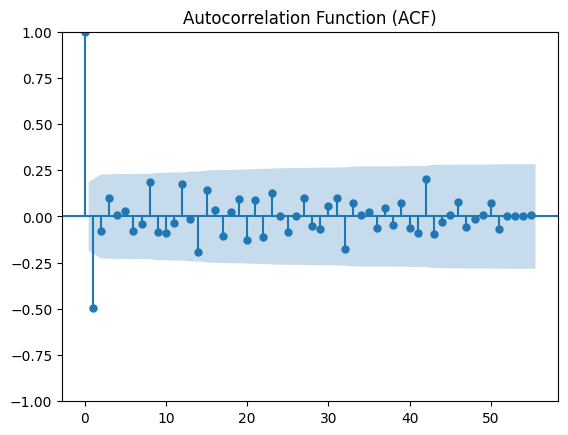

<Figure size 1200x600 with 0 Axes>

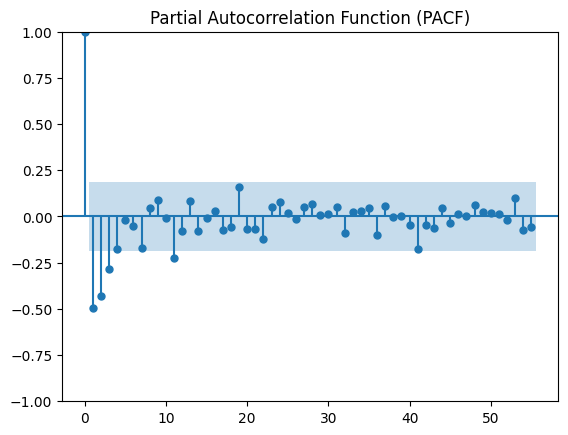


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  112
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -644.395
Date:                Sat, 12 Apr 2025   AIC                           1298.791
Time:                        15:32:54   BIC                           1312.338
Sample:                             0   HQIC                          1304.287
                                - 112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0966      0.509     -0.190      0.849      -1.094       0.900
ar.L2         -0.2131      0.134     -1.593      0.111      -0.475       0.0

<Figure size 1200x600 with 0 Axes>

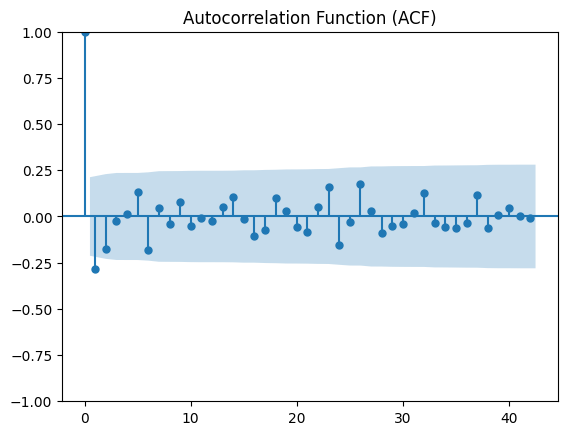

<Figure size 1200x600 with 0 Axes>

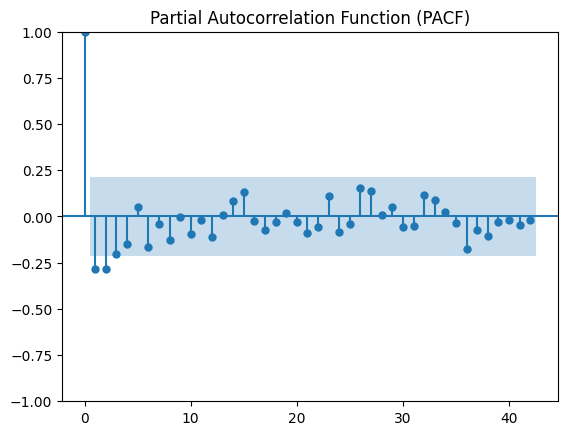


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -549.224
Date:                Sat, 12 Apr 2025   AIC                           1112.447
Time:                        15:32:58   BIC                           1129.546
Sample:                             0   HQIC                          1119.325
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1054      0.190     -5.810      0.000      -1.478      -0.733
ar.L2         -0.5508      0.290     -1.902      0.057      -1.118       0.0

<Figure size 1200x600 with 0 Axes>

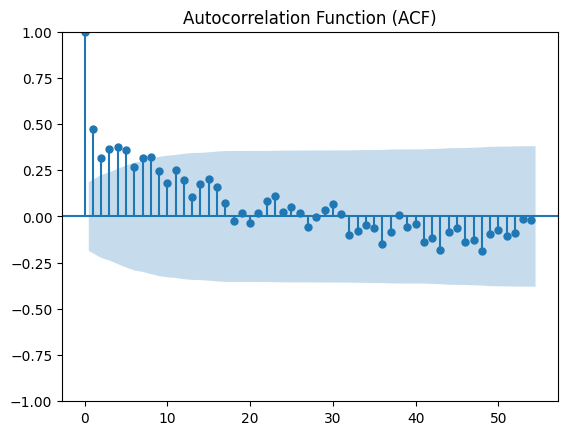

<Figure size 1200x600 with 0 Axes>

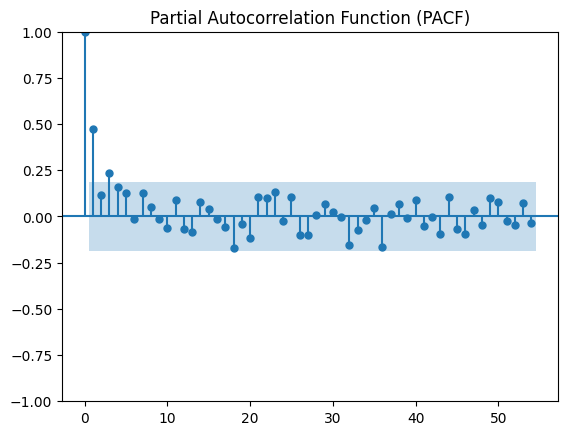


Fitting ARIMA model with order (3, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  111
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -836.330
Date:                Sat, 12 Apr 2025   AIC                           1682.660
Time:                        15:33:02   BIC                           1696.208
Sample:                             0   HQIC                          1688.156
                                - 111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1485.7204   1670.678      0.889      0.374   -1788.749    4760.190
ar.L1          0.7852      0.048     16.280      0.000       0.691       0.8

<Figure size 1200x600 with 0 Axes>

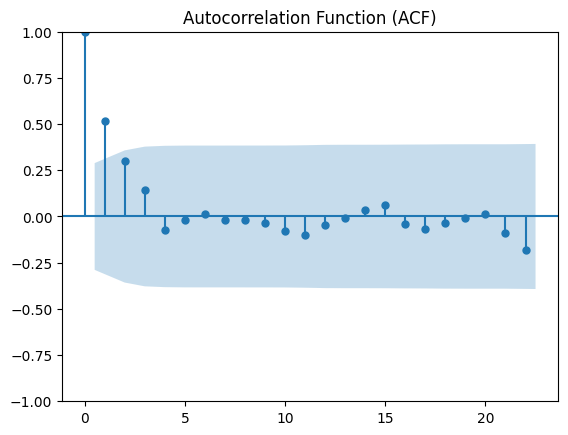

<Figure size 1200x600 with 0 Axes>

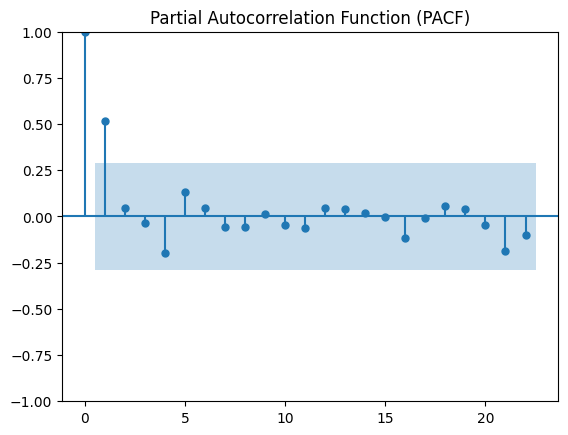


Fitting ARIMA model with order (2, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   46
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -363.045
Date:                Sat, 12 Apr 2025   AIC                            734.090
Time:                        15:33:05   BIC                            741.404
Sample:                             0   HQIC                           736.830
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5289.1303    232.212     22.777      0.000    4834.004    5744.257
ar.L1          0.4977      0.139      3.570      0.000       0.224       0.7

<Figure size 1200x600 with 0 Axes>

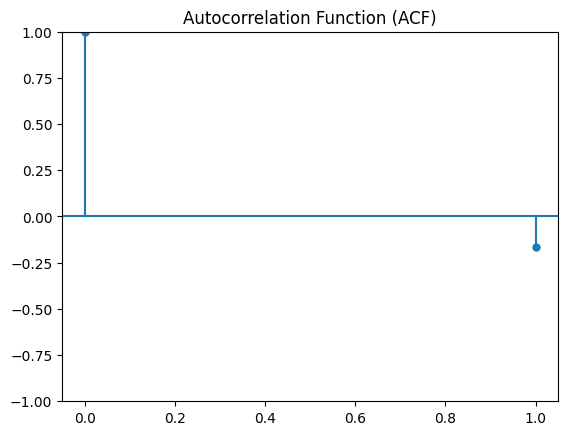

<Figure size 1200x600 with 0 Axes>

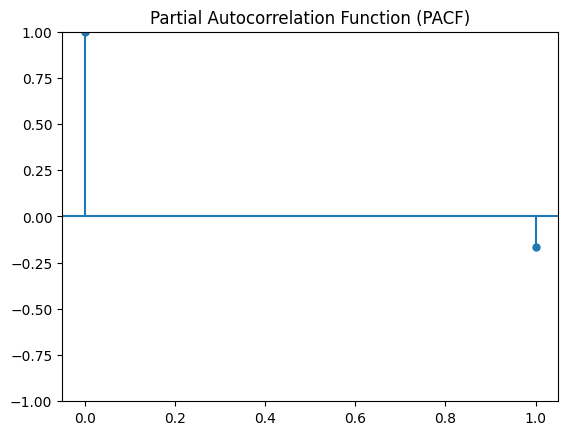


Fitting ARIMA model with order (0, 1, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    4
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -17.464
Date:                Sat, 12 Apr 2025   AIC                             36.928
Time:                        15:33:07   BIC                             36.027
Sample:                             0   HQIC                            35.116
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6666.4187   1.09e+04      0.612      0.540   -1.47e+04     2.8e+04
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for અનાનસ uploaded to Spaces at ml_models/fruits_saved_models/arima_model_100bdc7c160cbdb4295a7b9fa243e26a.pkl
લિચી size:  2
ઓરેંજ size:  1
હાફુસ કેરી size:  33
True
Checking stationarity for the raw price data of હાફુસ કેરી:

ADF Test Results:
ADF Statistic: -0.3372
p-value: 0.9201
Critical Value 1%: -3.6996
Critical Value 5%: -2.9764
Critical Value 10%: -2.6276
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.0512
p-value: 0.0000
Critical Value 1%: -3.6996
Critical Value 5%: -2.9764
Critical Value 10%: -2.6276
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -5.0512
p-value: 0.0000
Critical Value 1%: -3.6996
Critical Value 5%: -2.9764
Critical Value 10%: -2.6276
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [1 3 5]
Significant spikes in PACF (p): 4 at lags [ 1 

<Figure size 1200x600 with 0 Axes>

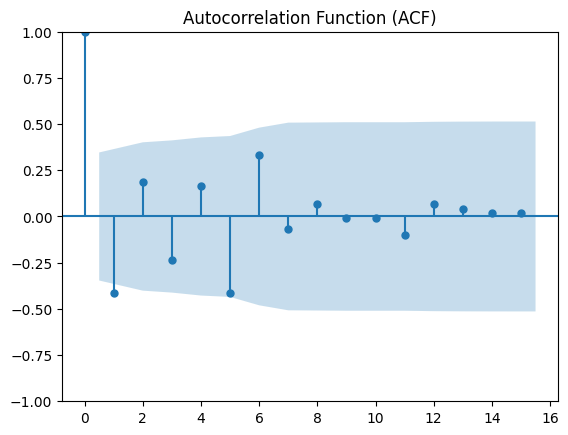

<Figure size 1200x600 with 0 Axes>

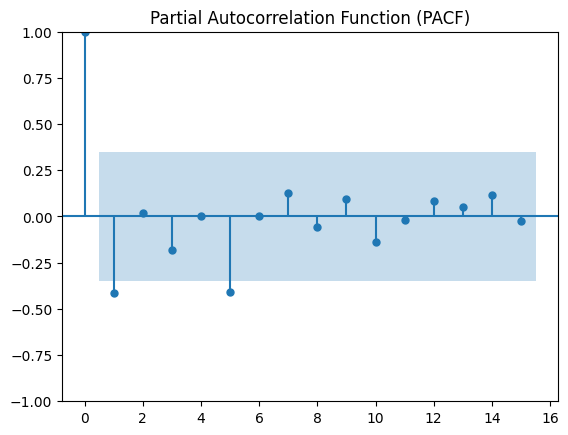


Fitting ARIMA model with order (4, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   33
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -263.172
Date:                Sat, 12 Apr 2025   AIC                            542.344
Time:                        15:33:10   BIC                            554.070
Sample:                             0   HQIC                           546.231
                                 - 33                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7475      0.317     -2.358      0.018      -1.369      -0.126
ar.L2          0.2078      0.501      0.415      0.678      -0.774       1.1

<Figure size 1200x600 with 0 Axes>

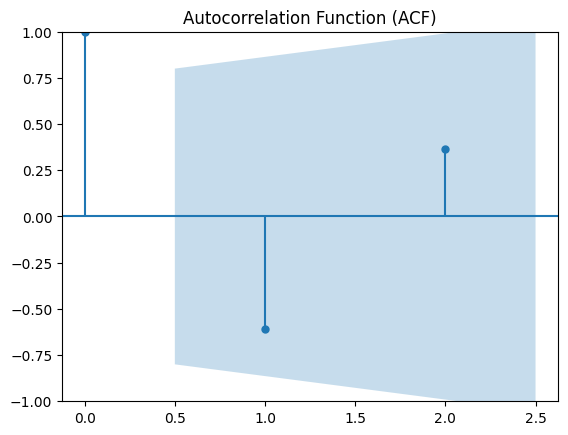

<Figure size 1200x600 with 0 Axes>

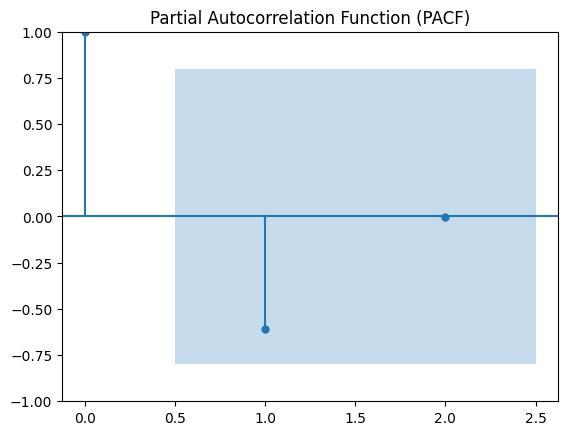


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.371
Date:                Sat, 12 Apr 2025   AIC                            102.742
Time:                        15:33:13   BIC                            102.117
Sample:                             0   HQIC                           100.241
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0465      1.109     -0.042      0.967      -2.219       2.126
ma.L1         -1.0000      1.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for લાલબાગ કેરી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_bd14fb01213332e76677dd9973ba9efa.pkl
બદામ કેરી size:  11
True
Checking stationarity for the raw price data of બદામ કેરી:

ADF Test Results:
ADF Statistic: -2.2499
p-value: 0.1886
Critical Value 1%: -4.3316
Critical Value 5%: -3.2330
Critical Value 10%: -2.7487
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.6254
p-value: 0.0879
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -3.0543
p-value: 0.0301
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.0543
p-value: 0.0301
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical V

<Figure size 1200x600 with 0 Axes>

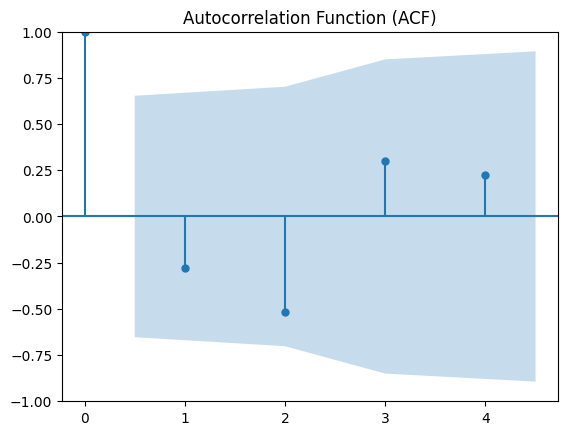

<Figure size 1200x600 with 0 Axes>

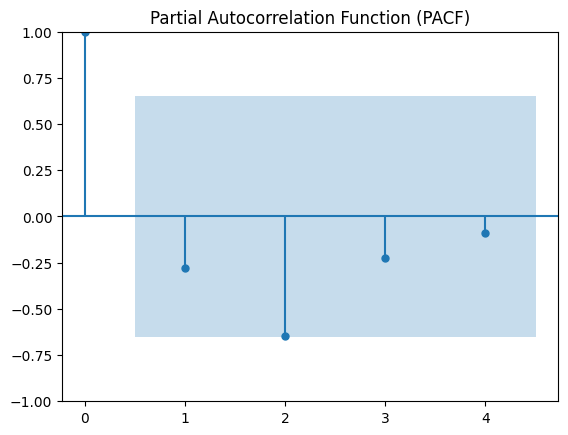


Fitting ARIMA model with order (2, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   11
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 -71.002
Date:                Sat, 12 Apr 2025   AIC                            150.004
Time:                        15:33:15   BIC                            150.793
Sample:                             0   HQIC                           148.302
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5420      0.344     -1.577      0.115      -1.216       0.132
ar.L2         -0.7989      0.18

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for બદામ કેરી uploaded to Spaces at ml_models/fruits_saved_models/arima_model_46daf60519d107dba885afbf32a83114.pkl
સૂ્દરી કેરી size:  2
કેસર કેરી size:  26
True
Checking stationarity for the raw price data of કેસર કેરી:

ADF Test Results:
ADF Statistic: -2.2243
p-value: 0.1976
Critical Value 1%: -3.7239
Critical Value 5%: -2.9865
Critical Value 10%: -2.6328
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.5404
p-value: 0.0000
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -5.5404
p-value: 0.0000
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [ 1  3 10]
Significant spikes in PACF (p): 8 at lags [1 2 3 

<Figure size 1200x600 with 0 Axes>

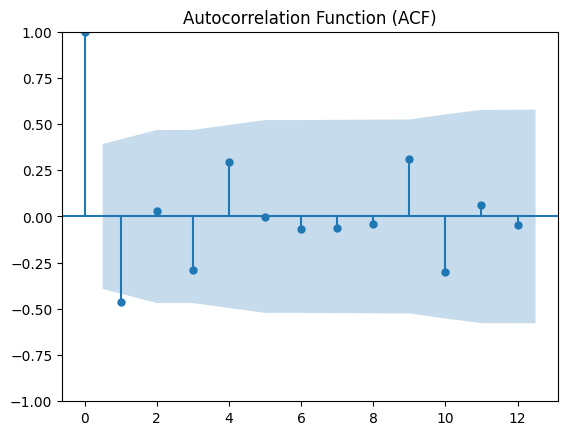

<Figure size 1200x600 with 0 Axes>

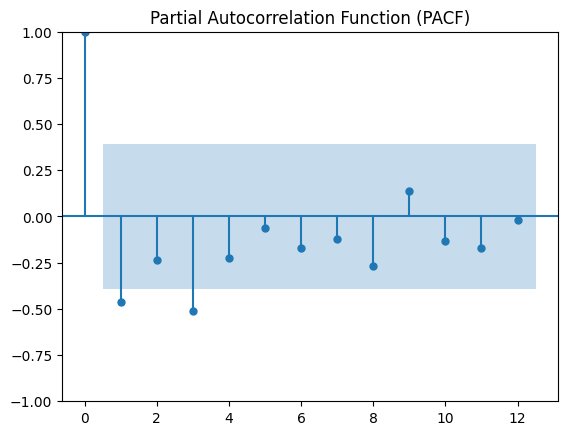


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   26
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -204.903
Date:                Sat, 12 Apr 2025   AIC                            423.806
Time:                        15:33:19   BIC                            432.338
Sample:                             0   HQIC                           426.172
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3158      0.373     -0.847      0.397      -1.047       0.415
ar.L2         -0.8325      0.139     -6.010      0.000      -1.104      -0.5

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
import boto3
import io
from dotenv import load_dotenv
load_dotenv()


###------------------------------------------------------------------------------------------------------------------------------
# Setup your DigitalOcean Spaces client
def get_spaces_client():
    return boto3.client(
        's3',
        region_name="sfo3",
        endpoint_url="https://apmc-temp1.sfo3.digitaloceanspaces.com",
        aws_access_key_id="DO006VCVK9FPAWM636M8",
        aws_secret_access_key="ruF10lqcc29K3Zokw80cGqPAXGOBRxsjZar2222NQnU"
    )

def dump_model_to_spaces(model, product, category):
    try:
        # Prepare filename
        hashed_name = safe_filename(product)
        filename = f"arima_model_{hashed_name}.pkl"
        key = f"ml_models/{category}/{filename}"  # e.g., ml_models/fruits_saved_models/arima_model_apple.pkl
        bucket = "apmc-temp1"
        print(f"Uploading to bucket: {bucket} with key: {key}")

        # Serialize model to bytes
        bytes_buffer = io.BytesIO()
        joblib.dump(model, bytes_buffer)
        bytes_buffer.seek(0)

        # Upload to Spaces
        client = get_spaces_client()
        client.put_object(Bucket="apmc-temp1", Key=key, Body=bytes_buffer)

        print(f"Model for {product} uploaded to Spaces at {key}")
    except Exception as e:
        print(f"Error uploading model for {product} to Spaces: {e}")
        

def filterData(existing_data):
    data = existing_data
    
    # Get current date and calculate the cutoff date (4 months ago)
    current_date = datetime.today()
    cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
    cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

    # today_date = datetime.now().strftime("%d/%m/%Y")

    # Filter data to keep only the last 4 months
    filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]
    
    return filtered_data


def append_csv_to_spaces(new_df: pd.DataFrame, filename: str):
    client = get_spaces_client()
    key = f"data/fruits/{filename}"

    try:
        # Step 1: Download existing file if it exists
        existing = client.get_object(Bucket="apmc-temp1", Key=key)
        existing_data = pd.read_csv(existing['Body'])
        print("📥 Existing CSV loaded from Spaces.")
        
        if(filename == "fruits_price_data.csv"):
            existing_data = filterData(existing_data)
            

        # Step 2: Append new data
        combined_df = pd.concat([existing_data, new_df], ignore_index=True)

    except client.exceptions.NoSuchKey:
        print("ℹ️ No existing file found. Creating a new one.")
        combined_df = new_df

    # Step 3: Upload updated CSV
    csv_buffer = io.StringIO()
    combined_df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    client.put_object(Bucket="apmc-temp1", Key=key, Body=csv_buffer.getvalue())

    print(f"✅ CSV saved to Spaces at {key}")



products_with_boxcox = []
### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/fruits/fruits_price_data.csv"


# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/fruits_saved_models"
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
allYearsFilename = base_dir / "data/fruits/fruits_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)
        
        
        columns = ["Date", "Some Extra Column", "Item Name", "Low Price", "Average Price", "High Price"]
        new_df = pd.DataFrame(data, columns=columns)
        print("Before dropping the column:")
        print(new_df.head())
        

        # Drop the column at index 1 (which corresponds to "Item Name")
        new_df.drop(new_df.columns[1], axis=1, inplace=True)
        
        print("\nAfter dropping the column:")
        print(new_df.head())
        
        new_df['Average Price'], new_df['High Price'] = new_df['High Price'], new_df['Average Price']

        # Print the new DataFrame to verify
        print("\nAfter rearranging the column:")
        print(new_df.head())


        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        append_csv_to_spaces(new_df, "fruits_price_data.csv")
        write_to_csv(data, allYearsFilename)
        append_csv_to_spaces(new_df, "fruits_price_data-all_years.csv")
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("FRUITS_WEBPAGE_PATH"),
                                           os.getenv("FRUITS_DATE_PATH"),
                                           os.getenv("FRUITS_SUBMIT_BUTTON_PATH"),
                                           os.getenv("FRUITS_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            dump_model_to_spaces(model_fit, product, "fruits_saved_models")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
